# Loading code metrics

First we will load class and method level code metrics from the csv files for each repository.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the data
collected_metrics = {}
for project_name in tqdm(os.listdir('/content/drive/MyDrive/appliedStatisticProject/CollectedMetrics/')):
    class_metrics = None
    method_metrics = None
    try:
        for file in glob(f'/content/drive/MyDrive/appliedStatisticProject/CollectedMetrics/{project_name}/*.csv'):
            df = pd.read_csv(file)
            df['project'] = project_name
            if file.endswith('Class.csv'):
                class_metrics = df
            elif file.endswith('Method.csv'):
                method_metrics = df
            else:
                raise Exception('Unknown file type')
            collected_metrics[project_name] = (class_metrics, method_metrics)
    except Exception as e:
        print(f'Error in {project_name}: {e}')

100%|██████████| 118/118 [00:05<00:00, 20.63it/s]


In [ ]:
projects = list(collected_metrics.keys())

In [ ]:
collected_metrics[projects[0]][0].head()

,ID,Name,LongName,Parent,Component,Path,Line,Column,EndLine,EndColumn,...,WarningMinor,Anti Pattern,Clone Metric Rules,Cohesion Metric Rules,Complexity Metric Rules,Coupling Metric Rules,Documentation Metric Rules,Inheritance Metric Rules,Size Metric Rules,project
0,L142,ActionMods,AssistantComputerControl.ActionMods,L104,L103,D:\DataCollection\repos\AlbertMN_AssistantComp...,22,5,345,6,...,0,3,0,0,3,0,1,0,4,AlbertMN_AssistantComputerControl
1,L486,SoftwareUpdater,AssistantComputerControl.SoftwareUpdater,L104,L103,D:\DataCollection\repos\AlbertMN_AssistantComp...,20,5,237,6,...,0,1,0,1,1,1,1,0,2,AlbertMN_AssistantComputerControl
2,L375,ActionChecker,AssistantComputerControl.ActionChecker,L104,L103,D:\DataCollection\repos\AlbertMN_AssistantComp...,21,5,616,6,...,0,4,0,2,4,2,5,0,10,AlbertMN_AssistantComputerControl
3,L1037,Actions,AssistantComputerControl.Actions,L104,L103,D:\DataCollection\repos\AlbertMN_AssistantComp...,22,5,1202,6,...,0,11,16,1,11,0,1,0,9,AlbertMN_AssistantComputerControl
4,L1528,AdvancedSettings,AssistantComputerControl.AdvancedSettings,L104,L103,D:\DataCollection\repos\AlbertMN_AssistantComp...,9,5,77,6,...,0,1,10,1,0,0,1,0,3,AlbertMN_AssistantComputerControl


Now we need to select only several class and method level code metrics, which we determined in the analysis of the code metrics in the previous notebook.

In [ ]:
final_metrics_table = pd.read_csv('/content/drive/MyDrive/appliedStatisticProject/final_metrics_table.csv')
final_metrics_table.head()

,Abbreviation,Metric name,Category,Description
0,AD,API Documentation,Class,Ratio of the number of documented public metho...
1,CBO,Coupling Between Object classes,Class,Number of directly used other classes (e.g. by...
2,CC,Clone Coverage,Class,Ratio of code covered by code duplications in ...
3,CLOC,Comment Lines of Code,Class,Number of comment and documentation code lines...
4,DIT,Depth of Inheritance Tree,Class,Length of the path that leads from the class t...


In [ ]:
class_metrics = final_metrics_table[final_metrics_table['Category'] == 'Class']['Abbreviation'].values
method_metrics = final_metrics_table[final_metrics_table['Category'] == 'Method']['Abbreviation'].values

In [ ]:
for project_name in collected_metrics.keys():
    class_metrics_df = collected_metrics[project_name][0]
    method_metrics_df = collected_metrics[project_name][1]
    class_metrics_df = class_metrics_df[class_metrics]
    method_metrics_df = method_metrics_df[method_metrics]
    collected_metrics[project_name] = (class_metrics_df, method_metrics_df)

In [ ]:
collected_metrics[projects[0]][0].head()

,AD,CBO,CC,CLOC,DIT,DLOC,LCOM5,LLDC,LLOC,LOC,...,TNG,TNLG,TNLM,TNLPM,TNLS,TNM,TNOS,TNPM,TNS,WMC
0,0.500000,2,0.000000,36,0,5,1,0,253,324,...,0,0,7,3,0,7,144,3,0,79
1,0.000000,5,0.000000,15,0,0,2,0,176,218,...,0,0,5,3,0,5,118,3,0,44
2,0.222222,9,0.000000,35,0,2,3,0,456,559,...,1,1,13,10,0,13,282,10,0,123
3,0.078947,6,0.044637,78,0,6,2,64,1004,1179,...,0,0,46,37,0,46,548,37,0,268
4,0.000000,3,0.246429,48,0,8,3,0,172,224,...,0,0,6,1,0,6,130,1,0,12


# Cost functions

## Sammon's error function

In [ ]:
def sammons_error(X, Y):
    N = X.shape[0]
    sum_d = 0
    sum_error = 0

    for i in range(N):
        for j in range(i + 1, N):
            d = np.linalg.norm(X[i] - X[j])
            d_hat = np.linalg.norm(Y[i] - Y[j])

            if d != 0:
                err = ((d - d_hat) ** 2) / d
                sum_error += err
                sum_d += d

    return sum_error / sum_d if sum_d != 0 else 0

In [ ]:
from scipy.spatial.distance import pdist, squareform

def get_distances(X):
    dist_X = squareform(pdist(X, 'euclidean'))
    return dist_X, np.sum(dist_X), np.sum(dist_X ** 2)

def optimized_sammons_error(dist_X, sum_d, sum_d_squared, Y): # sum_d_squared for compatibility
    dist_Y = squareform(pdist(Y, 'euclidean'))

    with np.errstate(divide='ignore', invalid='ignore'):
        delta = dist_X - dist_Y
        error = np.where(dist_X != 0, (delta ** 2) / dist_X, 0)

    return np.sum(error) / sum_d

### Test Sammon's error function

In [ ]:
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
Y = np.array([[1, 2], [4, 5], [7, 8]])

dist_X, sum_d, sum_d_squared = get_distances(X)
sammons_error(X, Y), optimized_sammons_error(dist_X, sum_d, sum_d_squared, Y)

(0.03367350481121464, 0.03367350481121464)

## Kruskal's stress function

In [ ]:
def kruskals_stress(X, Y):
    N = X.shape[0]
    sum_d_squared = 0
    sum_stress = 0

    for i in range(N):
        for j in range(i + 1, N):
            d = np.linalg.norm(X[i] - X[j])
            d_hat = np.linalg.norm(Y[i] - Y[j])
            sum_d_squared += d ** 2
            sum_stress += (d - d_hat) ** 2

    return sum_stress / sum_d_squared if sum_d_squared != 0 else 0

In [ ]:
from scipy.spatial.distance import pdist, squareform

def optimized_kruskals_stress(dist_X, sum_d, sum_d_squared, Y): # sum_d for compatibility
    dist_Y = squareform(pdist(Y, 'euclidean'))

    delta = dist_X - dist_Y
    sum_stress = np.sum(delta ** 2)

    return sum_stress / sum_d_squared if sum_d_squared != 0 else 0

### Test Kruskal's stress function

In [ ]:
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
Y = np.array([[1, 2], [4, 5], [7, 8]])

dist_X, sum_d, sum_d_squared = get_distances(X)
kruskals_stress(X, Y), optimized_kruskals_stress(dist_X, sum_d, sum_d_squared, Y)

(0.033673504811214644, 0.033673504811214644)

## Fitness function

In [ ]:
def fitness_function(X, parameter_vector, cost_function, k):
    selected_metrics = X[:, parameter_vector.argsort()[-k:]]
    return cost_function(X, selected_metrics)

def get_fitness_function(X, cost_function, k):
    return lambda parameter_vector: fitness_function(X, parameter_vector, cost_function, k)

def optimized_fitness_function(X, X_dist, sum_d, sum_d_squared, parameter_vector, cost_function, k, cached_fitness_function):
    metrics = tuple(np.sort(parameter_vector.argsort()[-k:]))
    selected_metrics = X[:, metrics]
    if metrics not in cached_fitness_function:
        cached_fitness_function[metrics] = cost_function(X_dist, sum_d, sum_d_squared, selected_metrics)
    return cached_fitness_function[metrics]

def get_optimized_fitness_function(X, cost_function, k):
    dist_X, sum_d, sum_d_squared = get_distances(X)
    cached_fitness_function = {}
    return lambda parameter_vector: optimized_fitness_function(X, dist_X, sum_d, sum_d_squared, parameter_vector, cost_function, k, cached_fitness_function)

### Test fitness function

In [ ]:
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
parameter_vector = np.array([0.7, 0.9, 0.3])
fitness_function(X, parameter_vector, sammons_error, 2), fitness_function(X, parameter_vector, kruskals_stress, 2)

(0.03367350481121464, 0.033673504811214644)

# ACO

In [ ]:
import numpy as np

def aco(fitness_function, dim, num_ants=30, max_iter=100, bounds=None, alpha=1, beta=2, evaporation_rate=0.5, num_elite=5, Q=1, verbose=False):
    """
    Ant Colony Optimization (ACO) algorithm.

    Parameters:
    - fitness_function: The fitness function to be optimized.
    - dim: Dimensionality of the search space.
    - num_ants: Number of ants in the colony.
    - max_iter: Maximum number of iterations.
    - bounds: Bounds for the search space as a tuple (min, max).
    - alpha: Influence of pheromone trails.
    - beta: Influence of heuristic information.
    - evaporation_rate: Rate at which pheromone evaporates.
    - Q: Constant influencing the amount of pheromone deposited.
    - verbose: Whether to display progress information.

    Returns:
    - The best solution found and its fitness.
    """
    # Initialize pheromone levels
    if bounds:
        min_bound, max_bound = bounds
        pheromones = np.ones((num_ants, dim)) * (max_bound - min_bound)
    else:
        pheromones = np.ones((num_ants, dim))

    best_solution = None
    best_score = float('inf')

    for t in tqdm(range(max_iter), disable=not verbose):
        solutions = []
        scores = []

        for ant in range(num_ants):
            # Generating a solution taking into account pheromones
            if bounds:
                solution = min_bound + (max_bound - min_bound) * (pheromones[ant] ** alpha) / (pheromones[ant] ** alpha).sum()
            else:
                solution = np.random.rand(dim)

            solutions.append(solution)
            score = fitness_function(solution)
            scores.append(score)

            # Update the best solution if the current one is better
            if score < best_score:
                best_solution = solution.copy()
                best_score = score

        elite_ants = sorted(range(num_ants), key=lambda i: scores[i])[:num_elite]
        # Update pheromone levels
        for i in range(num_ants):
            pheromones[i] *= (1 - evaporation_rate)  # Evaporation
            pheromones[i] += Q / (scores[i] + 1e-10)  # Deposit pheromone based on solution quality

        for i in elite_ants:
            pheromones[i] += Q / (scores[i] + 1e-10)

        # Limiting pheromone values
        pheromones = np.clip(pheromones, 1e-10, 1e10)

        if verbose:
            print(f"Iteration {t + 1}/{max_iter}, Best fitness: {best_score}")

    return best_solution, best_score

## RSA

In [ ]:
def initialization(N, Dim, UB, LB):
    # Initialize the positions of solutions randomly within the bounds

    return np.random.uniform(LB, UB, (N, Dim))

In [ ]:
# RSA testing

def RSA(N, T, LB, UB, Dim, F_obj):
    Best_P = np.zeros(Dim)  # best positions
    Best_F = np.inf  # best fitness
    X = initialization(N, Dim, UB, LB)  # Initialize the positions of solution
    Xnew = np.zeros((N, Dim))
    Conv = np.zeros(T)  # Convergence array

    t = 0  # starting iteration
    Alpha = 0.1  # the best value
    Beta = 0.005  # the best value
    Ffun = np.zeros(N)  # old fitness values
    Ffun_new = np.zeros(N)  # new fitness values

    # Calculate initial fitness values
    for i in range(N):
        Ffun[i] = F_obj(X[i])
        if Ffun[i] < Best_F:
            Best_F = Ffun[i]
            Best_P = X[i]

    while t < T:  # Main loop
        ES = 2 * np.random.randint(-1, 1) * (1 - (t / T))  # Probability Ratio
        for i in range(1, N):
            for j in range(Dim):
                R = Best_P[j] - X[np.random.randint(N), j] / (Best_P[j] + np.finfo(float).eps)
                P = Alpha + (X[i, j] - np.mean(X[i])) / (Best_P[j] * (UB - LB) + np.finfo(float).eps)
                Eta = Best_P[j] * P
                if t < T / 4:
                    Xnew[i, j] = Best_P[j] - Eta * Beta - R * np.random.rand()
                elif t < 2 * T / 4:
                    Xnew[i, j] = Best_P[j] * X[np.random.randint(N), j] * ES * np.random.rand()
                elif t < 3 * T / 4:
                    Xnew[i, j] = Best_P[j] * P * np.random.rand()
                else:
                    Xnew[i, j] = Best_P[j] - Eta * np.finfo(float).eps - R * np.random.rand()

            # Check boundaries
            Flag_UB = Xnew[i] > UB
            Flag_LB = Xnew[i] < LB
            Xnew[i] = (Xnew[i] * ~(Flag_UB | Flag_LB)) + UB * Flag_UB + LB * Flag_LB
            Ffun_new[i] = F_obj(Xnew[i])
            if Ffun_new[i] < Ffun[i]:
                X[i] = Xnew[i]
                Ffun[i] = Ffun_new[i]
            if Ffun[i] < Best_F:
                Best_F = Ffun[i]
                Best_P = X[i]

        Conv[t] = Best_F  # Update the convergence curve

        t += 1

    return Best_F, Best_P, Conv

# Finding the best subset of code metrics

First let's test the RSA algorithm with the Sammon's error function on one repository for k code metrics from 1 to number of code metrics.

We will select the project with the largest number of classes to see the performance of the algorithms.

In [ ]:
num_entities = []

for project in collected_metrics.keys():
    num_classes = collected_metrics[project][0].shape[0]
    num_methods = collected_metrics[project][1].shape[0]
    num_entities.append((project, num_classes, num_methods))

num_entities = pd.DataFrame(num_entities, columns=['project', 'num_classes', 'num_methods'])
num_entities.head()

,project,num_classes,num_methods
0,AlbertMN_AssistantComputerControl,26,404
1,antonpup_Aurora,1004,7175
2,asheigithub_apple-juice-actionscript,564,3720
3,bcgit_bc-csharp,2905,23204
4,aloneguid_parquet-dotnet,263,2515


In [ ]:
print(f'Project with the largest number of classes: {num_entities.iloc[num_entities["num_classes"].argmax()]["project"]}: {num_entities.iloc[num_entities["num_classes"].argmax()]["num_classes"]}')
print(f'Project with the largest number of methods: {num_entities.iloc[num_entities["num_methods"].argmax()]["project"]} {num_entities.iloc[num_entities["num_methods"].argmax()]["num_methods"]}')

In [ ]:
project_name = num_entities.iloc[num_entities["num_classes"].argmax()]["project"]

We will use step size of 3 for k to reduce the number of iterations.

# Testing RSA

In [ ]:
X = collected_metrics[project_name][0].values
scores_rsa = []
for k in tqdm(range(1, X.shape[1] + 1, 3)):
    sammon_error_fitness_function = get_optimized_fitness_function(X, optimized_sammons_error, k)
    best_fitness, best_solution, cov = RSA(N=6, T=70, LB=0, UB=1, Dim=X.shape[1], F_obj=sammon_error_fitness_function)
    scores_rsa.append(best_fitness)

100%|██████████| 14/14 [14:22<00:00, 61.59s/it]


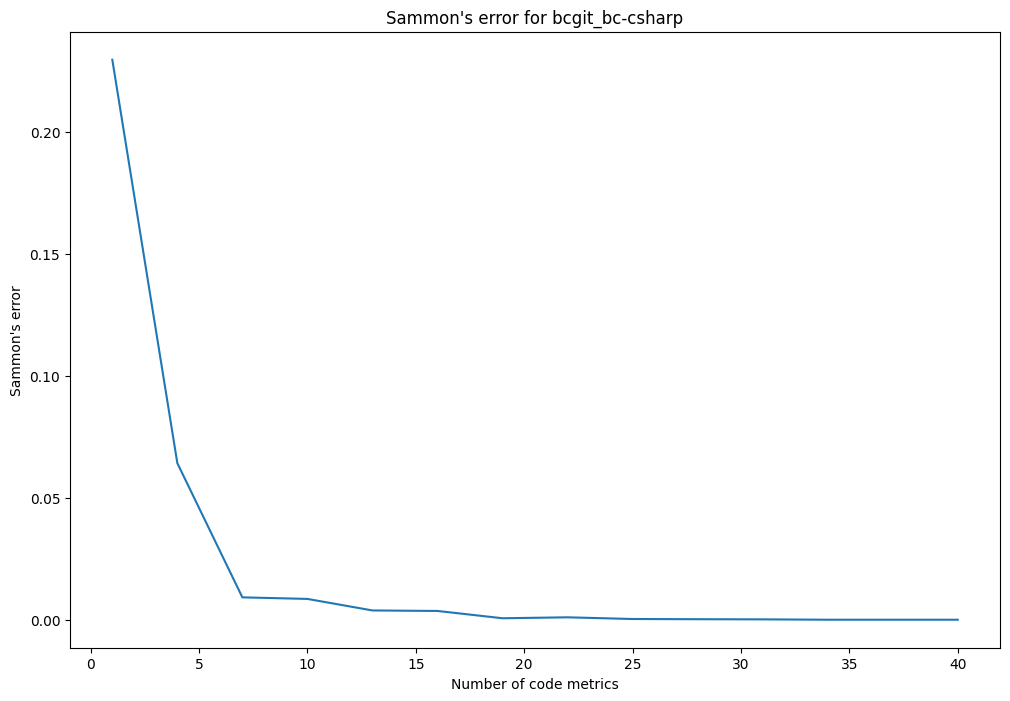

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, X.shape[1] + 1, 3), scores_rsa, label='RSA')
plt.xlabel('Number of code metrics')
plt.ylabel('Sammon\'s error')
plt.title(f'Sammon\'s error for {project_name}')
plt.show()

In [ ]:
X = collected_metrics[project_name][0].values
scores_rsa = []
for k in tqdm(range(1, X.shape[1] + 1, 3)):
    sammon_error_fitness_function = get_optimized_fitness_function(X, optimized_sammons_error, k)
    best_fitness, best_solution, cov = RSA(N=6, T=55, LB=0, UB=1, Dim=X.shape[1], F_obj=sammon_error_fitness_function)
    scores_rsa.append(best_fitness)

100%|██████████| 14/14 [11:47<00:00, 50.52s/it]


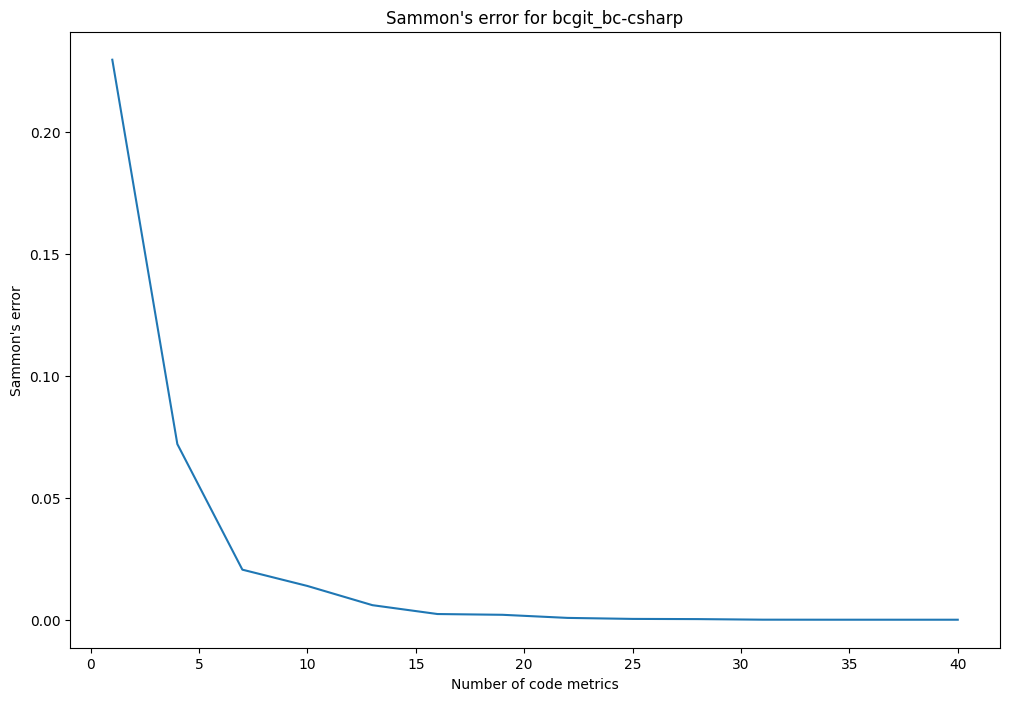

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, X.shape[1] + 1, 3), scores_rsa, label='RSA')
plt.xlabel('Number of code metrics')
plt.ylabel('Sammon\'s error')
plt.title(f'Sammon\'s error for {project_name}')
plt.show()

In [ ]:
X = collected_metrics[project_name][0].values
scores_rsa = []
for k in tqdm(range(1, X.shape[1] + 1, 3)):
    sammon_error_fitness_function = get_optimized_fitness_function(X, optimized_sammons_error, k)
    best_fitness, best_solution, cov = RSA(N=5, T=50, LB=0, UB=1, Dim=X.shape[1], F_obj=sammon_error_fitness_function)
    scores_rsa.append(best_fitness)

100%|██████████| 14/14 [08:31<00:00, 36.51s/it]


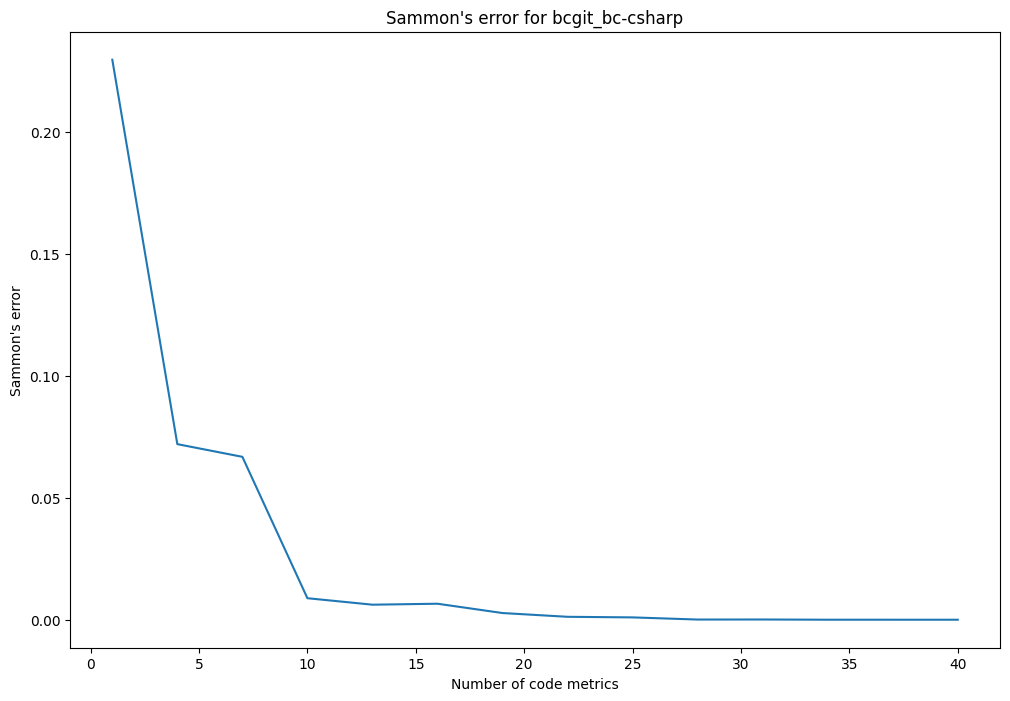

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, X.shape[1] + 1, 3), scores_rsa, label='RSA')
plt.xlabel('Number of code metrics')
plt.ylabel('Sammon\'s error')
plt.title(f'Sammon\'s error for {project_name}')
plt.show()

In [ ]:
X = collected_metrics[project_name][0].values
scores_rsa = []
for k in tqdm(range(1, X.shape[1] + 1, 3)):
    sammon_error_fitness_function = get_optimized_fitness_function(X, optimized_sammons_error, k)
    best_fitness, best_solution, cov = RSA(N=6, T=60, LB=0, UB=1, Dim=X.shape[1], F_obj=sammon_error_fitness_function)
    scores_rsa.append(best_fitness)

100%|██████████| 14/14 [12:38<00:00, 54.20s/it]


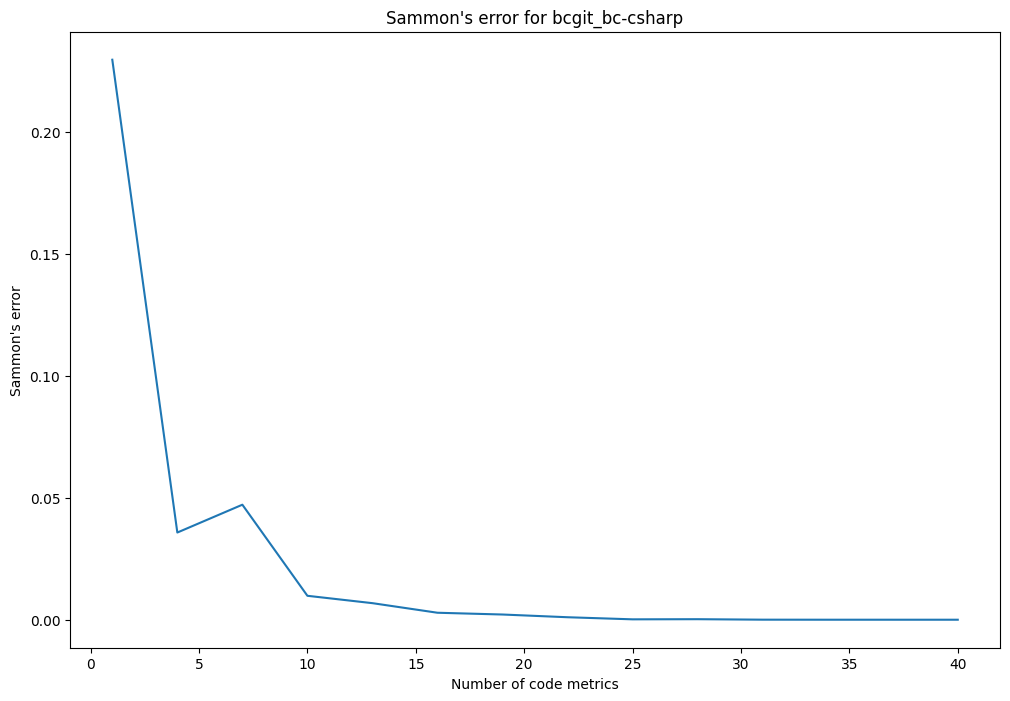

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, X.shape[1] + 1, 3), scores_rsa, label='RSA')
plt.xlabel('Number of code metrics')
plt.ylabel('Sammon\'s error')
plt.title(f'Sammon\'s error for {project_name}')
plt.show()

# ACO

In [ ]:
X = collected_metrics[project_name][0].values
scores_aco = []
for k in tqdm(range(1, X.shape[1] + 1, 3)):
    sammon_error_fitness_function = get_optimized_fitness_function(X, optimized_sammons_error, k)
    best_solution, best_fitness = aco(fitness_function=sammon_error_fitness_function, dim=X.shape[1], num_ants=30, max_iter=100, bounds=None, alpha=1, beta=2, evaporation_rate=0.5, num_elite=5, Q=1, verbose=False)
    scores_aco.append(best_fitness)

100%|██████████| 14/14 [14:14<00:00, 61.07s/it]


Now we will plot the scores for each k.

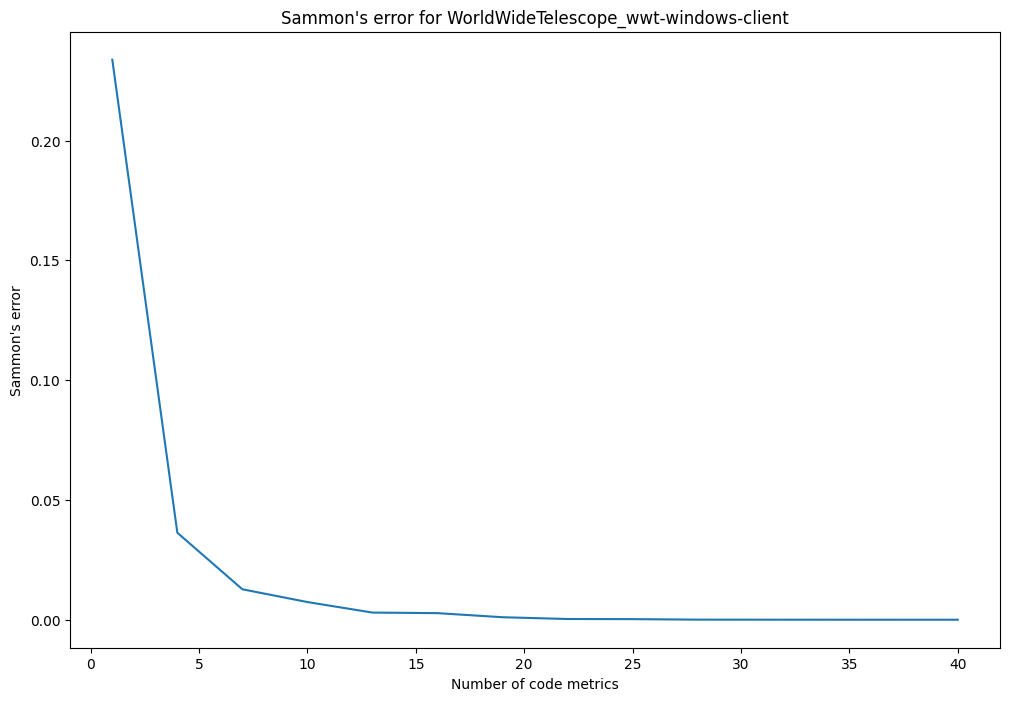

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, X.shape[1] + 1, 3), scores_aco, label='ACO')
plt.xlabel('Number of code metrics')
plt.ylabel('Sammon\'s error')
plt.title(f'Sammon\'s error for {project_name}')
plt.show()

# Finding the best subset of class metrics for all repositories

To save the results, we will use the following format:
- project_name
- k
- best_solution_rsa_sammon
- best_solution_rsa_kruskal
- best_fitness_rsa_sammon
- best_fitness_rsa_kruskal


Each repository will be processed 4 times (2 cost functions, 2 optimization algorithms). We will use 8 cores to speed up the process.

In [ ]:
def compute_scores(project_name, k, X):
    sammon_error_fitness_function = get_optimized_fitness_function(X, optimized_sammons_error, k)
    kruskal_stress_fitness_function = get_optimized_fitness_function(X, optimized_kruskals_stress, k)

    # RSA
    best_fitness_rsa_sammon, best_solution_rsa_sammon, cov_samon = RSA(N=6, T=55, LB=0, UB=1, Dim=X.shape[1], F_obj=sammon_error_fitness_function)
    best_fitness_rsa_kruskal, best_solution_rsa_kruskal, cov_kruskal = RSA(N=6, T=55, LB=0, UB=1, Dim=X.shape[1], F_obj=kruskal_stress_fitness_function)

    return (k, best_solution_rsa_sammon, best_solution_rsa_kruskal, best_fitness_rsa_sammon, best_fitness_rsa_kruskal)

In [ ]:
from concurrent.futures import ProcessPoolExecutor
from itertools import repeat

def process_project(project_name):
    X = collected_metrics[project_name][0].values
    k_values = range(1, X.shape[1] + 1, 2)

    with ProcessPoolExecutor(max_workers=8) as executor:
        results = list(executor.map(compute_scores, repeat(project_name), k_values, repeat(X)))

    return results

def save_table(results):
    df = pd.DataFrame(results, columns=['project_name', 'k', 'best_solution_rsa_sammon', 'best_solution_rsa_kruskal', 'best_fitness_rsa_sammon', 'best_fitness_rsa_kruskal'])
    df.to_csv('class_metrics_results.csv', index=False)

    html = df.to_html()
    with open('class_metrics_results.html', 'w') as f:
        f.write(html)

def process_projects(projects):
    results = []
    for project_name in tqdm(projects):
        res = process_project(project_name)
        for r in res:
            results.append((project_name, *r))
        save_table(results)
    return results

In [ ]:
process_projects(projects)

 31%|███       | 36/118 [1:08:11<46:02, 33.69s/it]<ipython-input-11-88e16406973b>:14: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(error) / sum_d
<ipython-input-11-88e16406973b>:14: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(error) / sum_d
<ipython-input-11-88e16406973b>:14: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(error) / sum_d
<ipython-input-11-88e16406973b>:14: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(error) / sum_d
<ipython-input-11-88e16406973b>:14: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(error) / sum_d
<ipython-input-11-88e16406973b>:14: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(error) / sum_d
<ipython-input-11-88e16406973b>:14: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(error) / sum_d
<ipython-input-11-88e16406973b>:14: RuntimeWarning: invalid value en

[('AlbertMN_AssistantComputerControl',
  1,
  array([0.92694254, 0.78702556, 0.267977  , 0.34027745, 0.79749819,
         0.77926559, 0.58454513, 1.        , 0.5795796 , 0.82707758,
         1.        , 1.        , 0.48543839, 0.96574961, 1.        ,
         0.8549779 , 0.65446701, 1.        , 0.93572846, 0.69817982,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         0.63990601, 1.        , 1.        , 0.90065416, 1.        ,
         0.68691464, 1.        , 1.        , 0.82829417, 0.96116899,
         1.        , 0.85067339, 1.        , 0.80057067, 0.89820138]),
  array([0.        , 0.04774257, 0.02527759, 0.        , 0.01627365,
         0.07796136, 0.        , 0.        , 0.        , 0.15735143,
         0.        , 0.        , 0.        , 0.1508737 , 0.16445592,
         0.1081531 , 0.06400788, 0.        , 0.01379178, 0.        ,
         0.        , 0.19734401, 0.04228589, 0.24911581, 0.09158364,
         0.07249912, 0.        , 0.23440761, 0.        , 

# Finding the best subset of method metrics for all repositories

A lot of repositories have more than 4000 methods, so we will use only 4000 randomly selected methods, because the optimization algorithms are very slow.

In [ ]:
def get_random_methods(df, num_methods=4000):
    df_n = df.fillna(0)
    if df_n.shape[0] <= num_methods:
        return df_n
    else:
        return df_n.sample(num_methods, random_state=42)

In [ ]:
# test
get_random_methods(collected_metrics['dib0_NHapiTools'][1]).shape

(4000, 14)

In [ ]:
from concurrent.futures import ProcessPoolExecutor
from itertools import repeat

def process_project(project_name):
    X = get_random_methods(collected_metrics[project_name][1]).values
    k_values = range(1, X.shape[1] + 1, 1)

    with ProcessPoolExecutor(max_workers=8) as executor:
        results = list(executor.map(compute_scores, repeat(project_name), k_values, repeat(X)))

    return results

def save_table(results):
    df = pd.DataFrame(results, columns=['project_name', 'k', 'best_solution_rsa_sammon', 'best_solution_rsa_kruskal', 'best_fitness_rsa_sammon', 'best_fitness_rsa_kruskal'])
    df.to_csv('method_metrics_results.csv', index=False)

    html = df.to_html()
    with open('method_metrics_results.html', 'w') as f:
        f.write(html)

def process_projects(projects):
    results = []
    for project_name in tqdm(projects):
        res = process_project(project_name)
        for r in res:
            results.append((project_name, *r))
        save_table(results)
    return results

In [ ]:
process_projects(projects)

 40%|███▉      | 47/118 [7:09:39<11:50:08, 600.12s/it]

# Analyzing the results

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

## ACO Result

In [ ]:
class_metrics_results_aco = pd.read_csv('class_metrics_results_aco.csv')
class_metrics_results_aco = class_metrics_results_aco.replace([np.inf, -np.inf], np.nan)

In [ ]:
class_metrics_results_aco['best_fitness_rsa_kruskal'] = np.sqrt(class_metrics_results_aco['best_fitness_rsa_kruskal'])

In [ ]:
class_metrics_results_aco.head()

,project_name,k,best_solution_rsa_sammon,best_solution_rsa_kruskal,best_fitness_rsa_sammon,best_fitness_rsa_kruskal
0,microsoft_powerapps-tools,1,[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1...,0.267967,0.470413
1,microsoft_powerapps-tools,3,[1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0...,[0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0...,0.155958,0.354984
2,microsoft_powerapps-tools,5,[0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1...,[0 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0...,0.059880,0.257075
3,microsoft_powerapps-tools,7,[0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1...,[0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0...,0.047919,0.153789
4,microsoft_powerapps-tools,9,[0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0...,[0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0...,0.040321,0.145086


In [ ]:
method_metrics_results_aco = pd.read_csv('method_metrics_results_aco.csv')
method_metrics_results_aco = method_metrics_results_aco.replace([np.inf, -np.inf], np.nan)

method_metrics_results_aco['best_fitness_rsa_kruskal'] = np.sqrt(method_metrics_results_aco['best_fitness_rsa_kruskal'])

In [ ]:
method_metrics_results_aco.head()

,project_name,k,best_solution_rsa_sammon,best_solution_rsa_kruskal,best_fitness_rsa_sammon,best_fitness_rsa_kruskal
0,microsoft_powerapps-tools,1,[1 0 1 0 0 0 1 1 1 1 0 0 1 0],[1 1 1 1 0 1 1 1 1 1 0 0 1 0],0.272607,0.494637
1,microsoft_powerapps-tools,2,[0 0 0 0 1 0 0 1 1 0 0 1 1 0],[0 0 0 0 1 1 0 0 0 0 0 0 1 0],0.132579,0.296833
2,microsoft_powerapps-tools,3,[0 0 0 0 0 1 0 0 0 0 0 1 1 0],[0 0 0 0 1 1 0 0 0 0 0 0 1 0],0.055481,0.149736
3,microsoft_powerapps-tools,4,[0 0 0 0 0 1 0 0 0 0 0 0 0 0],[0 0 0 0 0 1 0 0 0 0 0 0 0 0],0.040717,0.138480
4,microsoft_powerapps-tools,5,[0 0 0 0 1 1 0 0 0 0 0 0 0 0],[0 0 0 0 1 1 0 0 0 0 0 0 1 0],0.019560,0.033039


## GWO Result

In [ ]:
class_metrics_results_gwo = pd.read_csv('class_metrics_results_gwo.csv')
class_metrics_results_gwo = class_metrics_results_gwo.replace([np.inf, -np.inf], np.nan)

In [ ]:
class_metrics_results_gwo['best_fitness_gwo_kruskal'] = np.sqrt(class_metrics_results_gwo['best_fitness_gwo_kruskal'])

In [ ]:
class_metrics_results_gwo.head()

,project_name,k,best_solution_gwo_sammon,best_solution_gwo_kruskal,best_fitness_gwo_sammon,best_fitness_gwo_kruskal
0,simon-knuth_scanner,1,[0.52800623 0.59476405 0.04692871 0.28065094 0...,[0.6358623 0.40555862 0.69208257 0.09047471 0...,0.161985,0.402474
1,simon-knuth_scanner,3,[2.62551492e-01 6.80341865e-01 1.86660536e-01 ...,[0.54251649 0.69281366 0.2461361 0.35333143 0...,0.090734,0.317179
2,simon-knuth_scanner,5,[0.1034946 0. 0.00455887 0.12116169 0...,[0.36557816 0.0847173 0.04947604 0.73970383 0...,0.001566,0.039573
3,simon-knuth_scanner,7,[0.23892806 0.50222998 0.00609582 0.28824167 0...,[0.38774145 0.29903083 0.25871977 0.07211868 0...,0.000585,0.025109
4,simon-knuth_scanner,9,[0.67001448 0.04590412 0.76405897 0.95159646 0...,[0.19842443 0.60478832 0.31247189 0.01031578 0...,0.004979,0.037515


In [ ]:
method_metrics_results_gwo = pd.read_csv('method_metrics_results_gwo.csv')
method_metrics_results_gwo = method_metrics_results_gwo.replace([np.inf, -np.inf], np.nan)

method_metrics_results_gwo['best_fitness_gwo_kruskal'] = np.sqrt(method_metrics_results_gwo['best_fitness_gwo_kruskal'])

In [ ]:
method_metrics_results_gwo.head()

,project_name,k,best_solution_gwo_sammon,best_solution_gwo_kruskal,best_fitness_gwo_sammon,best_fitness_gwo_kruskal
0,microsoft_powerapps-tools,1,[0.32403579 0.95492599 0.68685958 0.1845943 0...,[0.62190774 0.72842757 0.58125573 0.02580464 0...,0.272607,0.494637
1,microsoft_powerapps-tools,2,[0.12715794 0.44807206 0.30607115 0.61175883 0...,[0.27451626 0.09370947 0.16882391 0.67699839 0...,0.120865,0.296833
2,microsoft_powerapps-tools,3,[0.1933806 1. 0. 0.21968697 0...,[0.27451626 0.09370947 0.16882391 0.67699839 0...,0.055481,0.147658
3,microsoft_powerapps-tools,4,[0.23484646 0.17285073 0.53543241 0.35002819 0...,[0.58041034 0.39476649 0.37570895 0. 1...,0.028523,0.046886
4,microsoft_powerapps-tools,5,[0.12021129 0.39608184 0.28556527 0.03621228 0...,[0.25486416 0.04456423 0.15614332 0.28906287 0...,0.016822,0.033039


## RSA Result

In [ ]:
class_metrics_results_rsa = pd.read_csv('class_metrics_results_rsa.csv')
class_metrics_results_rsa = class_metrics_results_rsa.replace([np.inf, -np.inf], np.nan)

In [ ]:
class_metrics_results_rsa['best_fitness_rsa_kruskal'] = np.sqrt(class_metrics_results_rsa['best_fitness_rsa_kruskal'])

In [ ]:
class_metrics_results_rsa.head()

,project_name,k,best_solution_rsa_sammon,best_solution_rsa_kruskal,best_fitness_rsa_sammon,best_fitness_rsa_kruskal
0,AlbertMN_AssistantComputerControl,1,[0.92694254 0.78702556 0.267977 0.34027745 0...,[0. 0.04774257 0.02527759 0. 0...,0.233781,0.478107
1,AlbertMN_AssistantComputerControl,3,[0.0323668 0. 0. 0.0376152 0...,[0. 0. 0.00278714 0. 0...,0.068632,0.254929
2,AlbertMN_AssistantComputerControl,5,[0.00000000e+00 9.04732884e-03 1.35965313e-02 ...,[0.00013464 0. 0. 0. 0...,0.085901,0.191812
3,AlbertMN_AssistantComputerControl,7,[0.00027805 0. 0.00206958 0. 0...,[0. 0. 0.00757211 0.0002062 0...,0.022287,0.149326
4,AlbertMN_AssistantComputerControl,9,[0. 0. 0. 0. 0...,[0. 0. 0. 0.00434265 0...,0.019318,0.081809


In [ ]:
method_metrics_results_rsa = pd.read_csv('method_metrics_results_rsa.csv')
method_metrics_results_rsa = method_metrics_results_rsa.replace([np.inf, -np.inf], np.nan)

method_metrics_results_rsa['best_fitness_rsa_kruskal'] = np.sqrt(method_metrics_results_rsa['best_fitness_rsa_kruskal'])

In [ ]:
method_metrics_results_rsa.head()

,project_name,k,best_solution_rsa_sammon,best_solution_rsa_kruskal,best_fitness_rsa_sammon,best_fitness_rsa_kruskal
0,AlbertMN_AssistantComputerControl,1,[0.75060694 0.93723209 0.99671244 0.96659533 0...,[0. 0. 0.03289718 0.17112422 0...,0.328178,0.504707
1,AlbertMN_AssistantComputerControl,2,[0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0.],[0.96987649 0.68748657 0.96615293 0.9974291 0...,0.137614,0.335417
2,AlbertMN_AssistantComputerControl,3,[0. 0. 0. 0. 1...,[1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.],0.068967,0.263273
3,AlbertMN_AssistantComputerControl,4,[0. 0. 0. 0. 0...,[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1.],0.020183,0.160241
4,AlbertMN_AssistantComputerControl,5,[0.88783514 0.98267243 1. 1. 0...,[0.08726161 0. 0. 0. 0...,0.016509,0.191551


## Split the data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

projects_train, projects_val = train_test_split(projects, test_size=0.3, random_state=42)
print(f'Number of projects in training set: {len(projects_train)}')
print(f'Number of projects in validation set: {len(projects_val)}')

Number of projects in training set: 82
Number of projects in validation set: 36


In [ ]:
# save the split
with open('projects_train.txt', 'w') as f:
    for project in projects_train:
        f.write(f'{project}\n')

with open('projects_val.txt', 'w') as f:
    for project in projects_val:
        f.write(f'{project}\n')

In [ ]:
# load the split
with open('projects_train.txt', 'r') as f:
    projects_train = [line.strip() for line in f.readlines()]

with open('projects_val.txt', 'r') as f:
    projects_val = [line.strip() for line in f.readlines()]

print(f'Number of projects in training set: {len(projects_train)}')
print(f'Number of projects in validation set: {len(projects_val)}')

Number of projects in training set: 82
Number of projects in validation set: 36


## ACO data

In [ ]:
class_metrics_results_train_aco = class_metrics_results_aco[class_metrics_results_aco['project_name'].isin(projects_train)]
class_metrics_results_val_aco = class_metrics_results_aco[class_metrics_results_aco['project_name'].isin(projects_val)]

method_metrics_results_train_aco = method_metrics_results_aco[method_metrics_results_aco['project_name'].isin(projects_train)]
method_metrics_results_val_aco = method_metrics_results_aco[method_metrics_results_aco['project_name'].isin(projects_val)]

## GWO data

In [ ]:
class_metrics_results_train_gwo = class_metrics_results_gwo[class_metrics_results_gwo['project_name'].isin(projects_train)]
class_metrics_results_val_gwo = class_metrics_results_gwo[class_metrics_results_gwo['project_name'].isin(projects_val)]

method_metrics_results_train_gwo = method_metrics_results_gwo[method_metrics_results_gwo['project_name'].isin(projects_train)]
method_metrics_results_val_gwo = method_metrics_results_gwo[method_metrics_results_gwo['project_name'].isin(projects_val)]

## RSA data

In [ ]:
class_metrics_results_train_rsa = class_metrics_results_rsa[class_metrics_results_rsa['project_name'].isin(projects_train)]
class_metrics_results_val_rsa = class_metrics_results_rsa[class_metrics_results_rsa['project_name'].isin(projects_val)]

method_metrics_results_train_rsa = method_metrics_results_rsa[method_metrics_results_rsa['project_name'].isin(projects_train)]
method_metrics_results_val_rsa = method_metrics_results_rsa[method_metrics_results_rsa['project_name'].isin(projects_val)]

In [ ]:
!pip install tikzplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 1.1 MB/s eta 0:00:00


In [ ]:
!pip install -U matplotlib tikzplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 49.8 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfully uninstalled matplotlib-3.8.0


In [ ]:
!pip uninstall -y matplotlib tikzplotlib
!pip install matplotlib==3.5.3 tikzplotlib
!pip uninstall webcolors
!pip install webcolors==1.11.1

Found existing installation: matplotlib 3.5.3
Uninstalling matplotlib-3.5.3:
  Successfully uninstalled matplotlib-3.5.3
Found existing installation: tikzplotlib 0.10.1
Uninstalling tikzplotlib-0.10.1:
  Successfully uninstalled tikzplotlib-0.10.1
  Using cached matplotlib-3.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached tikzplotlib-0.10.1-py3-none-any.whl.metadata (8.9 kB)
Using cached matplotlib-3.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.9 MB)
Using cached tikzplotlib-0.10.1-py3-none-any.whl (54 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.25.0 requires matplotlib>=3.7.1, but you have matplotlib 3.5.3 which is incompatible.
plotnine 0.14.1 requires matplotlib>=3.8.0, but you have matplotlib 3.5.3 which is incompatible.


Found existing installation: webcolors 24.8.0
Uninstalling webcolors-24.8.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/webcolors-24.8.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/webcolors/*
Proceed (Y/n)? ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/uninstall.py", line 106, in run
    uninstall_pathset = req.uninstall(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_install.py", line 722, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_uninstall.py", line 364, in remove
    if auto_confirm or self._allowed_to_proceed(verbose):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_uninstall.py

## Fitness function values plot

We will plot the average, minimum and maximum fitness function values for each k aggregated over all repositories for class and method metrics.

### ACO

In [ ]:
class_values_at_k_aco = class_metrics_results_train_aco.groupby('k').agg({'best_fitness_rsa_sammon': ['mean', 'min', 'max'], 'best_fitness_rsa_kruskal': ['mean', 'min', 'max']})
class_values_at_k_aco.head()

best_fitness_rsa_sammon                     best_fitness_rsa_kruskal  \
                     mean       min       max                     mean   
k                                                                        
1                0.250087  0.161985  0.511323                 0.471816   
3                0.142318  0.101030  0.224269                 0.367712   
5                0.043459  0.012710  0.161368                 0.254661   
7                0.037629  0.012708  0.096437                 0.145570   
9                0.032311  0.009974  0.082608                 0.140384   

                       
        min       max  
k                      
1  0.361733  0.705956  
3  0.329396  0.474764  
5  0.151808  0.372942  
7  0.090720  0.353997  
9  0.086122  0.320228

In [ ]:
method_values_at_k_aco = method_metrics_results_train_aco.groupby('k').agg({'best_fitness_rsa_sammon': ['mean', 'min', 'max'], 'best_fitness_rsa_kruskal': ['mean', 'min', 'max']})
method_values_at_k_aco.head()

best_fitness_rsa_sammon                     best_fitness_rsa_kruskal  \
                     mean       min       max                     mean   
k                                                                        
1                0.292176  0.234404  0.384880                 0.509448   
2                0.162897  0.117762  0.252297                 0.319264   
3                0.072429  0.030513  0.138892                 0.218143   
4                0.052848  0.021880  0.103555                 0.173226   
5                0.027375  0.005256  0.057768                 0.097635   

                       
        min       max  
k                      
1  0.355813  0.599426  
2  0.199264  0.461407  
3  0.149502  0.366771  
4  0.123425  0.293428  
5  0.033039  0.217666

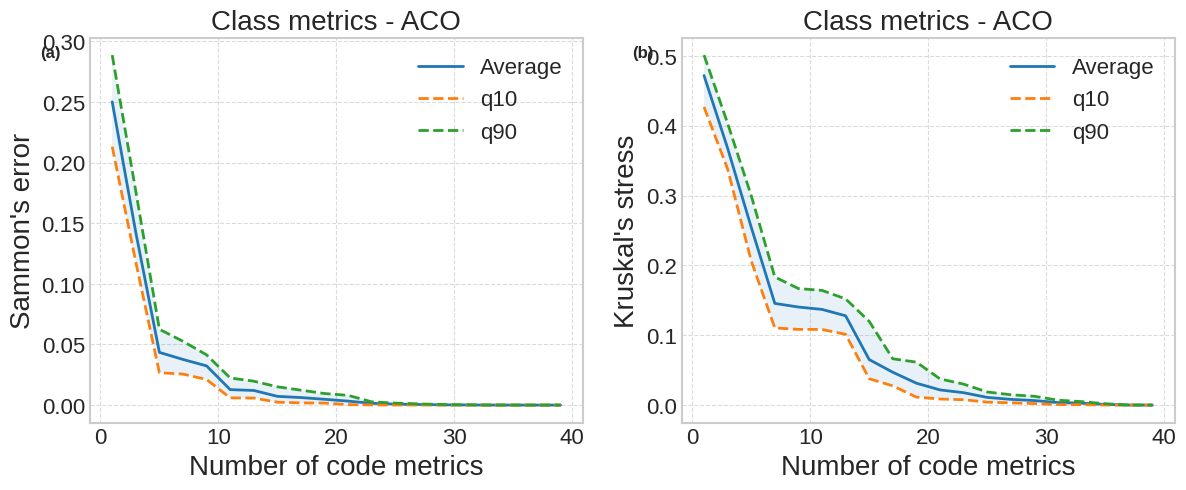

In [ ]:
class_values_at_k2 = class_metrics_results_train_aco.groupby('k').agg({'best_fitness_rsa_sammon': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))], 'best_fitness_rsa_kruskal': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))]})

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_rsa_sammon']['mean'], label='Average')
ax[0].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_rsa_sammon']['q10'], linestyle='dashed', label='q10')
ax[0].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_rsa_sammon']['q90'], linestyle='dashed', label='q90')
ax[0].fill_between(class_values_at_k2.index, class_values_at_k2['best_fitness_rsa_sammon']['q10'], class_values_at_k2['best_fitness_rsa_sammon']['q90'], alpha=0.1)
ax[0].set_xlabel('Number of code metrics')
ax[0].set_ylabel('Sammon\'s error')
ax[0].set_title('Class metrics - ACO')
ax[0].legend()

ax[1].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_rsa_kruskal']['mean'], label='Average')
ax[1].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_rsa_kruskal']['q10'], linestyle='dashed', label='q10')
ax[1].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_rsa_kruskal']['q90'], linestyle='dashed', label='q90')
ax[1].fill_between(class_values_at_k2.index, class_values_at_k2['best_fitness_rsa_kruskal']['q10'], class_values_at_k2['best_fitness_rsa_kruskal']['q90'], alpha=0.1)
ax[1].set_xlabel('Number of code metrics')
ax[1].set_ylabel('Kruskal\'s stress')
ax[1].set_title('Class metrics - ACO')
ax[1].legend()
tikzplotlib.save("class_metrics_aco.tex")
ax[0].text(-0.1, 0.95, '(a)', transform=ax[0].transAxes, size=12, weight='bold')
ax[1].text(-0.1, 0.95, '(b)', transform=ax[1].transAxes, size=12, weight='bold')


plt.show()



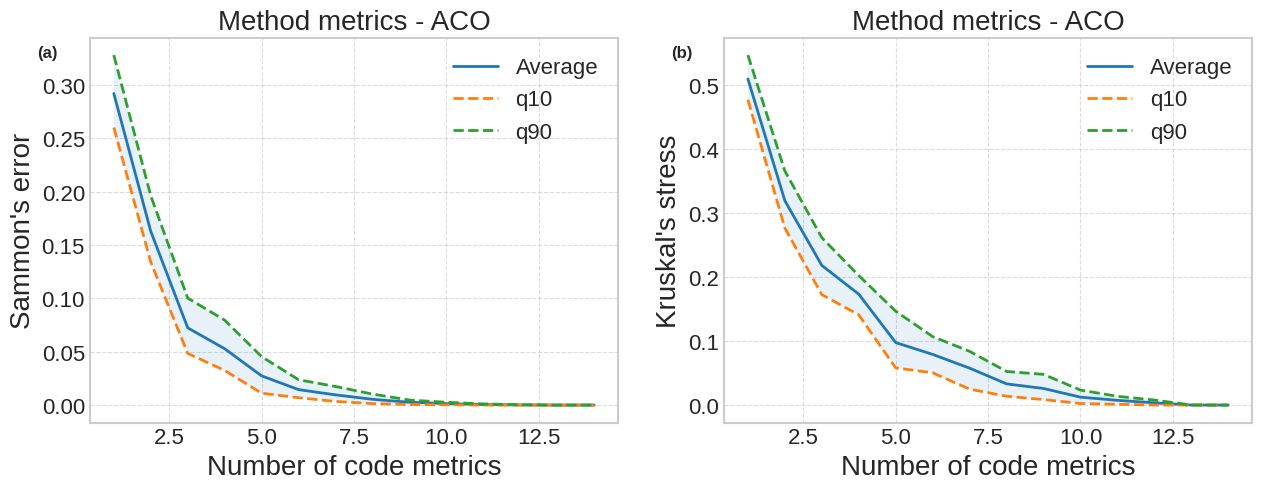

In [ ]:
method_values_at_k2 = method_metrics_results_train_aco.groupby('k').agg({'best_fitness_rsa_sammon': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))], 'best_fitness_rsa_kruskal': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))]})

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_rsa_sammon']['mean'], label='Average')
ax[0].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_rsa_sammon']['q10'], linestyle='dashed', label='q10')
ax[0].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_rsa_sammon']['q90'], linestyle='dashed', label='q90')
ax[0].fill_between(method_values_at_k2.index, method_values_at_k2['best_fitness_rsa_sammon']['q10'], method_values_at_k2['best_fitness_rsa_sammon']['q90'], alpha=0.1)
ax[0].set_xlabel('Number of code metrics')
ax[0].set_ylabel('Sammon\'s error')
ax[0].set_title('Method metrics - ACO')
ax[0].legend()


ax[1].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_rsa_kruskal']['mean'], label='Average')
ax[1].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_rsa_kruskal']['q10'], linestyle='dashed', label='q10')
ax[1].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_rsa_kruskal']['q90'], linestyle='dashed', label='q90')
ax[1].fill_between(method_values_at_k2.index, method_values_at_k2['best_fitness_rsa_kruskal']['q10'], method_values_at_k2['best_fitness_rsa_kruskal']['q90'], alpha=0.1)
ax[1].set_xlabel('Number of code metrics')
ax[1].set_ylabel('Kruskal\'s stress')
ax[1].set_title('Method metrics - ACO')
ax[1].legend()


ax[0].text(-0.1, 0.95, '(a)', transform=ax[0].transAxes, size=12, weight='bold')
ax[1].text(-0.1, 0.95, '(b)', transform=ax[1].transAxes, size=12, weight='bold')

plt.show()


### GWO

In [ ]:
class_values_at_k_gwo = class_metrics_results_train_gwo.groupby('k').agg({'best_fitness_gwo_sammon': ['mean', 'min', 'max'], 'best_fitness_gwo_kruskal': ['mean', 'min', 'max']})
class_values_at_k_gwo.head()

best_fitness_gwo_sammon                     best_fitness_gwo_kruskal  \
                     mean       min       max                     mean   
k                                                                        
1                0.250113  0.161985  0.511323                 0.471816   
3                0.075856  0.015410  0.218663                 0.208965   
5                0.025069  0.001566  0.095521                 0.094746   
7                0.013710  0.000404  0.068761                 0.064401   
9                0.006891  0.000082  0.029939                 0.048535   

                       
        min       max  
k                      
1  0.361733  0.705956  
3  0.109659  0.432445  
5  0.029220  0.294214  
7  0.006684  0.191776  
9  0.006530  0.158105

In [ ]:
method_values_at_k_gwo = method_metrics_results_train_gwo.groupby('k').agg({'best_fitness_gwo_sammon': ['mean', 'min', 'max'], 'best_fitness_gwo_kruskal': ['mean', 'min', 'max']})
method_values_at_k_gwo.head()

best_fitness_gwo_sammon                     best_fitness_gwo_kruskal  \
                     mean       min       max                     mean   
k                                                                        
1                0.292176  0.234404  0.384880                 0.509448   
2                0.137436  0.080748  0.240437                 0.319264   
3                0.072239  0.030513  0.138892                 0.213873   
4                0.039645  0.012323  0.074279                 0.133011   
5                0.022622  0.005256  0.052393                 0.090953   

                       
        min       max  
k                      
1  0.355813  0.599426  
2  0.199264  0.461407  
3  0.132095  0.328721  
4  0.046886  0.243851  
5  0.033039  0.188234

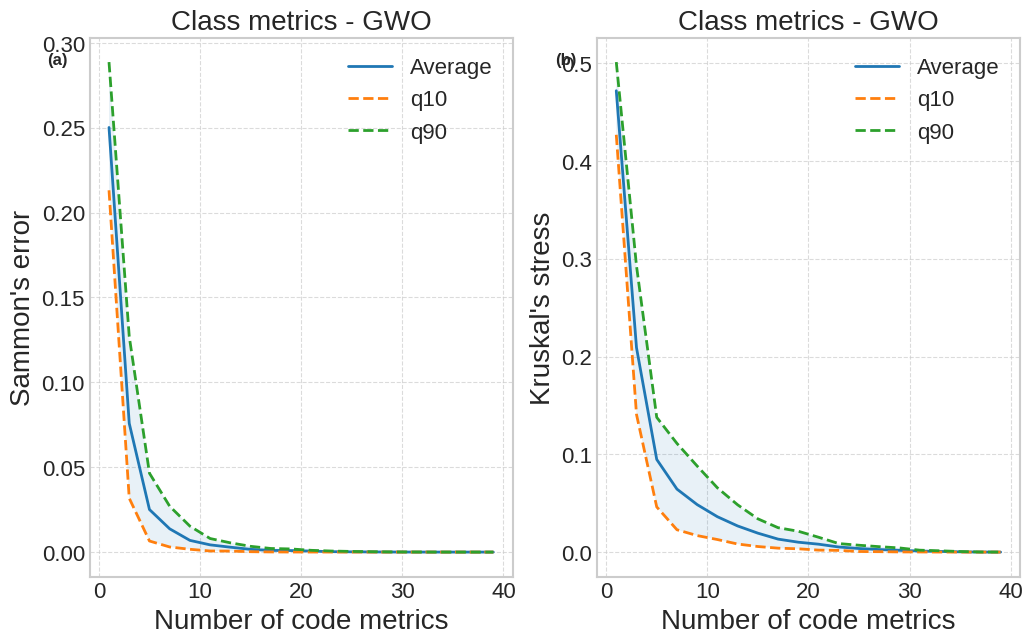

In [ ]:
class_values_at_k2 = class_metrics_results_train_gwo.groupby('k').agg({'best_fitness_gwo_sammon': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))], 'best_fitness_gwo_kruskal': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))]})

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_gwo_sammon']['mean'], label='Average')
ax[0].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_gwo_sammon']['q10'], linestyle='dashed', label='q10')
ax[0].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_gwo_sammon']['q90'], linestyle='dashed', label='q90')
ax[0].fill_between(class_values_at_k2.index, class_values_at_k2['best_fitness_gwo_sammon']['q10'], class_values_at_k2['best_fitness_gwo_sammon']['q90'], alpha=0.1)
ax[0].set_xlabel('Number of code metrics')
ax[0].set_ylabel('Sammon\'s error')
ax[0].set_title('Class metrics - GWO')
ax[0].legend()

ax[1].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_gwo_kruskal']['mean'], label='Average')
ax[1].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_gwo_kruskal']['q10'], linestyle='dashed', label='q10')
ax[1].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_gwo_kruskal']['q90'], linestyle='dashed', label='q90')
ax[1].fill_between(class_values_at_k2.index, class_values_at_k2['best_fitness_gwo_kruskal']['q10'], class_values_at_k2['best_fitness_gwo_kruskal']['q90'], alpha=0.1)
ax[1].set_xlabel('Number of code metrics')
ax[1].set_ylabel('Kruskal\'s stress')
ax[1].set_title('Class metrics - GWO')
ax[1].legend()

ax[0].text(-0.1, 0.95, '(a)', transform=ax[0].transAxes, size=12, weight='bold')
ax[1].text(-0.1, 0.95, '(b)', transform=ax[1].transAxes, size=12, weight='bold')

tikzplotlib.save("class_metrics_gwo.tex")
plt.show()



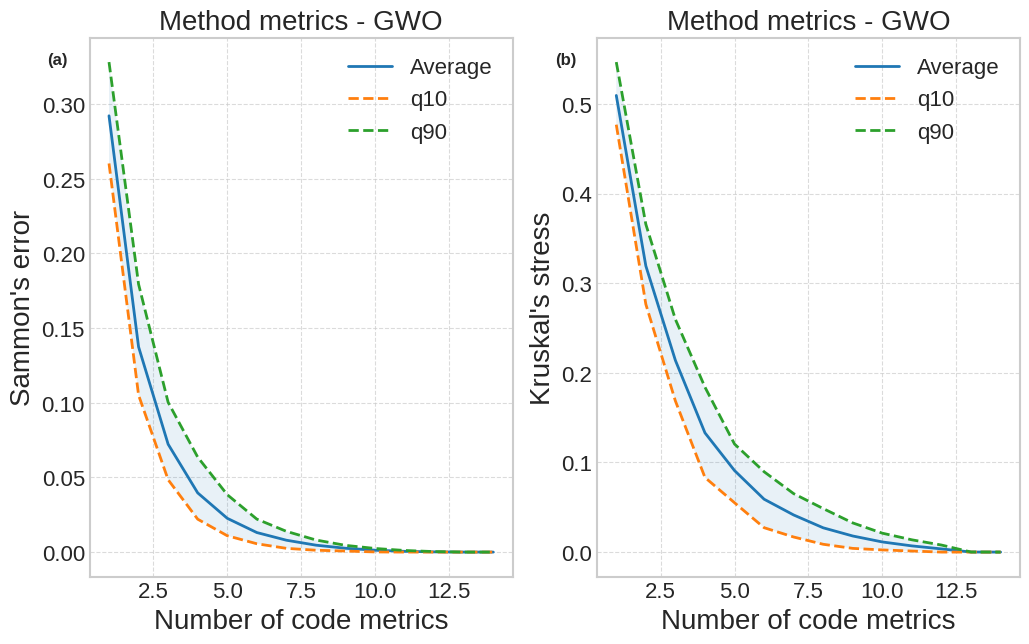

In [ ]:
method_values_at_k2 = method_metrics_results_train_gwo.groupby('k').agg({'best_fitness_gwo_sammon': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))], 'best_fitness_gwo_kruskal': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))]})

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_gwo_sammon']['mean'], label='Average')
ax[0].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_gwo_sammon']['q10'], linestyle='dashed', label='q10')
ax[0].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_gwo_sammon']['q90'], linestyle='dashed', label='q90')
ax[0].fill_between(method_values_at_k2.index, method_values_at_k2['best_fitness_gwo_sammon']['q10'], method_values_at_k2['best_fitness_gwo_sammon']['q90'], alpha=0.1)
ax[0].set_xlabel('Number of code metrics')
ax[0].set_ylabel('Sammon\'s error')
ax[0].set_title('Method metrics - GWO')
ax[0].legend()


ax[1].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_gwo_kruskal']['mean'], label='Average')
ax[1].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_gwo_kruskal']['q10'], linestyle='dashed', label='q10')
ax[1].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_gwo_kruskal']['q90'], linestyle='dashed', label='q90')
ax[1].fill_between(method_values_at_k2.index, method_values_at_k2['best_fitness_gwo_kruskal']['q10'], method_values_at_k2['best_fitness_gwo_kruskal']['q90'], alpha=0.1)
ax[1].set_xlabel('Number of code metrics')
ax[1].set_ylabel('Kruskal\'s stress')
ax[1].set_title('Method metrics - GWO')
ax[1].legend()


ax[0].text(-0.1, 0.95, '(a)', transform=ax[0].transAxes, size=12, weight='bold')
ax[1].text(-0.1, 0.95, '(b)', transform=ax[1].transAxes, size=12, weight='bold')

tikzplotlib.save("method_metrics_gwo.tex")
plt.show()

### RSA

In [ ]:
class_values_at_k_rsa = class_metrics_results_train_rsa.groupby('k').agg({'best_fitness_rsa_sammon': ['mean', 'min', 'max'], 'best_fitness_rsa_kruskal': ['mean', 'min', 'max']})
class_values_at_k_rsa.head()

best_fitness_rsa_sammon                     best_fitness_rsa_kruskal  \
                     mean       min       max                     mean   
k                                                                        
1                0.250518  0.161985  0.511323                 0.476829   
3                0.081462  0.024228  0.208550                 0.260751   
5                0.046170  0.005570  0.173959                 0.185100   
7                0.030713  0.006495  0.077144                 0.129925   
9                0.018357  0.000666  0.087185                 0.082329   

                       
        min       max  
k                      
1  0.361733  0.723555  
3  0.109659  0.472699  
5  0.063459  0.384746  
7  0.035504  0.235314  
9  0.021358  0.261822

In [ ]:
method_values_at_k_rsa = method_metrics_results_train_rsa.groupby('k').agg({'best_fitness_rsa_sammon': ['mean', 'min', 'max'], 'best_fitness_rsa_kruskal': ['mean', 'min', 'max']})
method_values_at_k_rsa.head()

best_fitness_rsa_sammon                     best_fitness_rsa_kruskal  \
                     mean       min       max                     mean   
k                                                                        
1                0.299862  0.237550  0.384880                 0.509527   
2                0.164209  0.110289  0.275812                 0.336562   
3                0.104415  0.058938  0.149819                 0.258194   
4                0.052656  0.008953  0.126550                 0.219364   
5                0.038505  0.013601  0.076377                 0.187657   

                       
        min       max  
k                      
1  0.355813  0.599426  
2  0.199264  0.491261  
3  0.144887  0.366771  
4  0.134889  0.328860  
5  0.094897  0.317016

In [ ]:
plt.style.use('seaborn-whitegrid')

plt.rcParams.update({
    'font.size': 16,                    # Larger font size
    'text.usetex': False,                # Use LaTeX to write all text
    'figure.figsize': (7, 5),           # Size of the figures
    'axes.labelsize': 20,               # Size of axis labels
    'axes.titlesize': 20,               # Size of the title
    'xtick.labelsize': 16,              # Size of the x-tick labels
    'ytick.labelsize': 16,              # Size of the y-tick labels
    'legend.fontsize': 16,              # Size of the legend
    'axes.linewidth': 1.5,              # Increase the axis line width
    'lines.linewidth': 2,               # Increase the line width
    'lines.markersize': 8,              # Increase marker size
    'xtick.major.width': 1.5,           # Increase x-tick line width
    'ytick.major.width': 1.5,           # Increase y-tick line width
    'xtick.minor.visible': True,        # Show x minor ticks
    'ytick.minor.visible': True,        # Show y minor ticks
    'grid.linestyle': '--',             # Dashed grid lines
    'grid.alpha': 0.7,                  # Transparency of grid lines
})

In [ ]:
import tikzplotlib

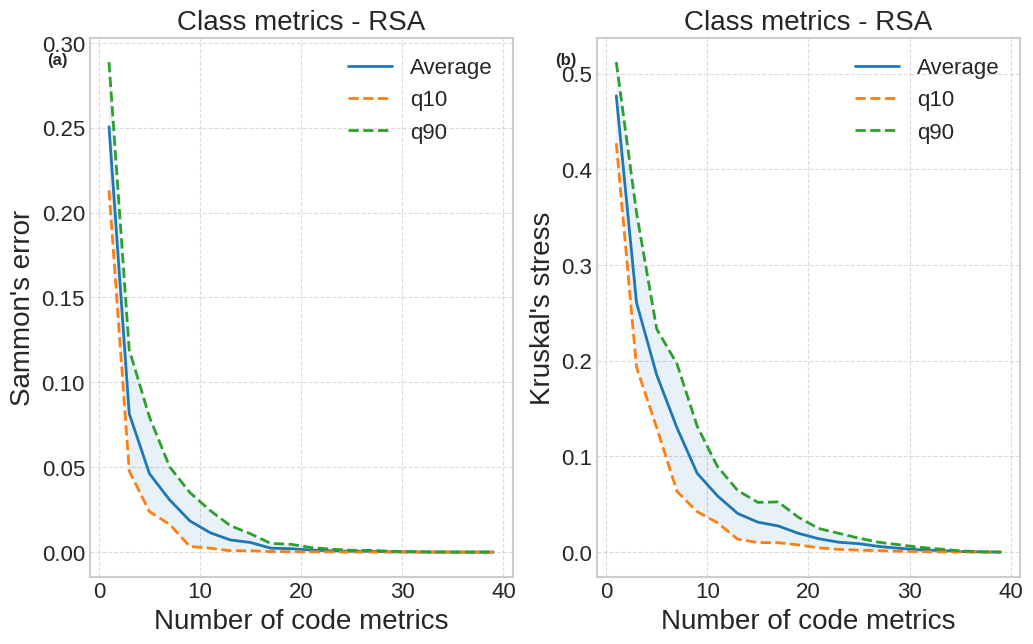

In [ ]:
class_values_at_k2 = class_metrics_results_train_rsa.groupby('k').agg({'best_fitness_rsa_sammon': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))], 'best_fitness_rsa_kruskal': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))]})

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_rsa_sammon']['mean'], label='Average')
ax[0].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_rsa_sammon']['q10'], linestyle='dashed', label='q10')
ax[0].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_rsa_sammon']['q90'], linestyle='dashed', label='q90')
ax[0].fill_between(class_values_at_k2.index, class_values_at_k2['best_fitness_rsa_sammon']['q10'], class_values_at_k2['best_fitness_rsa_sammon']['q90'], alpha=0.1)
ax[0].set_xlabel('Number of code metrics')
ax[0].set_ylabel('Sammon\'s error')
ax[0].set_title('Class metrics - RSA')
ax[0].legend()

ax[1].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_rsa_kruskal']['mean'], label='Average')
ax[1].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_rsa_kruskal']['q10'], linestyle='dashed', label='q10')
ax[1].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_rsa_kruskal']['q90'], linestyle='dashed', label='q90')
ax[1].fill_between(class_values_at_k2.index, class_values_at_k2['best_fitness_rsa_kruskal']['q10'], class_values_at_k2['best_fitness_rsa_kruskal']['q90'], alpha=0.1)
ax[1].set_xlabel('Number of code metrics')
ax[1].set_ylabel('Kruskal\'s stress')
ax[1].set_title('Class metrics - RSA')
ax[1].legend()

ax[0].text(-0.1, 0.95, '(a)', transform=ax[0].transAxes, size=12, weight='bold')
ax[1].text(-0.1, 0.95, '(b)', transform=ax[1].transAxes, size=12, weight='bold')

tikzplotlib.save("class_metrics_rsa.tex")
plt.show()

Now render the same plots for tikz latex.

q10 and q90 are much more stable than min and max.

Now we will plot the same for method metrics using q10 and q90.

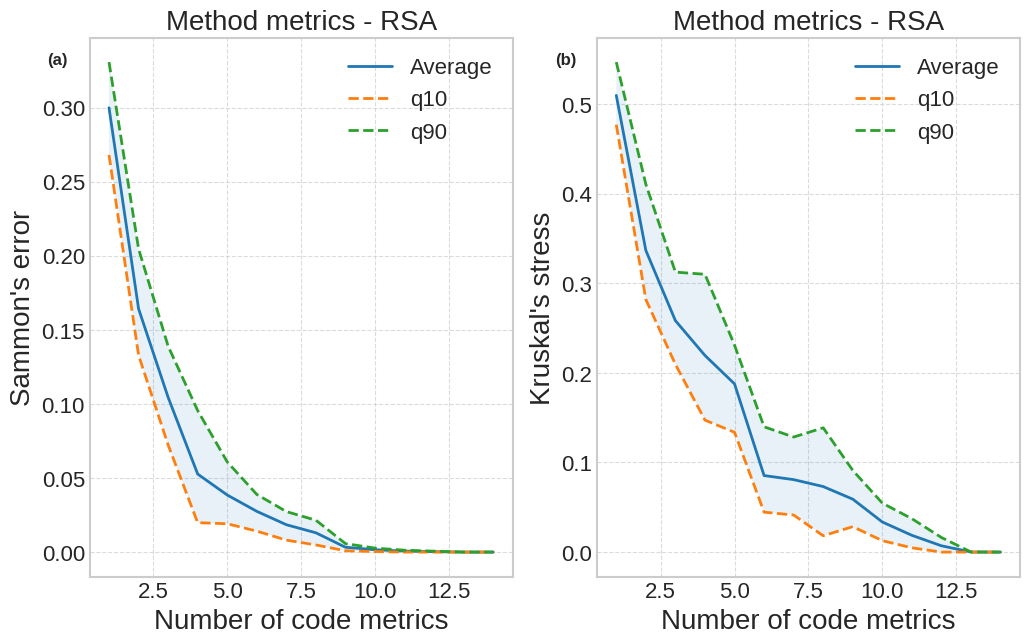

In [ ]:
method_values_at_k2 = method_metrics_results_train_rsa.groupby('k').agg({'best_fitness_rsa_sammon': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))], 'best_fitness_rsa_kruskal': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))]})

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_rsa_sammon']['mean'], label='Average')
ax[0].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_rsa_sammon']['q10'], linestyle='dashed', label='q10')
ax[0].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_rsa_sammon']['q90'], linestyle='dashed', label='q90')
ax[0].fill_between(method_values_at_k2.index, method_values_at_k2['best_fitness_rsa_sammon']['q10'], method_values_at_k2['best_fitness_rsa_sammon']['q90'], alpha=0.1)
ax[0].set_xlabel('Number of code metrics')
ax[0].set_ylabel('Sammon\'s error')
ax[0].set_title('Method metrics - RSA')
ax[0].legend()


ax[1].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_rsa_kruskal']['mean'], label='Average')
ax[1].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_rsa_kruskal']['q10'], linestyle='dashed', label='q10')
ax[1].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_rsa_kruskal']['q90'], linestyle='dashed', label='q90')
ax[1].fill_between(method_values_at_k2.index, method_values_at_k2['best_fitness_rsa_kruskal']['q10'], method_values_at_k2['best_fitness_rsa_kruskal']['q90'], alpha=0.1)
ax[1].set_xlabel('Number of code metrics')
ax[1].set_ylabel('Kruskal\'s stress')
ax[1].set_title('Method metrics - RSA')
ax[1].legend()


ax[0].text(-0.1, 0.95, '(a)', transform=ax[0].transAxes, size=12, weight='bold')
ax[1].text(-0.1, 0.95, '(b)', transform=ax[1].transAxes, size=12, weight='bold')

tikzplotlib.save("method_metrics_rsa.tex")
plt.show()


# Vote-counting aggregation

In [ ]:
def array_from_string(s):
    return np.fromstring(s[1:-1], dtype=np.float64, sep=' ')

In [ ]:
class_metrics_votes_rsa = {}
method_metrics_votes_rsa = {}
optimal_class_k = 9
optimal_method_k = 5

for project in projects:
    try:
        optimal_class_subset_rsa_samon = array_from_string(class_metrics_results_train_rsa[(class_metrics_results_train_rsa['project_name'] == project) & (class_metrics_results_train_rsa['k'] == optimal_class_k)].iloc[0]['best_solution_rsa_sammon']).argsort()[-optimal_class_k:]
        optimal_class_subset_rsa_kruskal = array_from_string(class_metrics_results_train_rsa[(class_metrics_results_train_rsa['project_name'] == project) & (class_metrics_results_train_rsa['k'] == optimal_class_k)].iloc[0]['best_solution_rsa_kruskal']).argsort()[-optimal_class_k:]

        optimal_method_subset_rsa_samon = array_from_string(method_metrics_results_train_rsa[(method_metrics_results_train_rsa['project_name'] == project) & (method_metrics_results_train_rsa['k'] == optimal_method_k)].iloc[0]['best_solution_rsa_sammon']).argsort()[-optimal_method_k:]
        optimal_method_subset_rsa_kruskal = array_from_string(method_metrics_results_train_rsa[(method_metrics_results_train_rsa['project_name'] == project) & (method_metrics_results_train_rsa['k'] == optimal_method_k)].iloc[0]['best_solution_rsa_kruskal']).argsort()[-optimal_method_k:]


        for i in optimal_class_subset_rsa_samon:
            if i in class_metrics_votes_rsa:
                class_metrics_votes_rsa[i] += 1
            else:
                class_metrics_votes_rsa[i] = 1

        for i in optimal_class_subset_rsa_kruskal:
            if i in class_metrics_votes_rsa:
                class_metrics_votes_rsa[i] += 1
            else:
                class_metrics_votes_rsa[i] = 1

        for i in optimal_method_subset_rsa_samon:
            if i in method_metrics_votes_rsa:
                method_metrics_votes_rsa[i] += 1
            else:
                method_metrics_votes_rsa[i] = 1

        for i in optimal_method_subset_rsa_kruskal:
            if i in method_metrics_votes_rsa:
                method_metrics_votes_rsa[i] += 1
            else:
                method_metrics_votes_rsa[i] = 1

    except:
        print(project)

method_metrics_votes_rsa

AlbertMN_AssistantComputerControl
aloneguid_parquet-dotnet
bitbeans_SimpleDnsCrypt
BlueMystical_EDHM_UI
bitwarden_mobile
compomics_ThermoRawFileParser
d2phap_ImageGlass
cabbagecreek_Marlin3DprinterTool
dram55_MarioMaker2OCR
dotnetprojects_DotNetSiemensPLCToolBoxLibrary
Doublevil_Houhou-SRS
dotnet_TorchSharp
hermitdave_FrequencyWords
GregBahm_PlaceViewer
hcmlab_nova
laochiangx_ABP-ASP.NET-Boilerplate-Project-CMS
hudec117_Mpv.NET-lib-
Koziev_NLP_Datasets
lofcz_SimplexRpgEngine
lunadream_XWall
monkog_3D-Virtual-Fitting-Room
miyconst_Mi899
mono_taglib-sharp
octgn_OCTGN
mperdeck_jsnlog
punker76_simple-music-player
WindowsGSM_WindowsGSM
rocksdanister_lively
saucepleez_taskt
SubtitleEdit_subtitleedit
sswelm_KSP-Interstellar-Extended
stefsietz_nn-visualizer
veldrid_veldrid
UnigramDev_Unigram
thesupersonic16_HedgeModManager
zlynn1990_SpaceSim


{5: 106,
 8: 103,
 11: 137,
 12: 144,
 13: 46,
 4: 109,
 6: 55,
 1: 40,
 3: 16,
 2: 16,
 10: 36,
 9: 10,
 7: 1,
 0: 1}

In [ ]:
class_metrics_votes_aco = {}
method_metrics_votes_aco = {}
optimal_class_k = 9
optimal_method_k = 5

for project in projects:
    try:
        optimal_class_subset_aco_samon = array_from_string(class_metrics_results_train_aco[(class_metrics_results_train_aco['project_name'] == project) & (class_metrics_results_train_aco['k'] == optimal_class_k)].iloc[0]['best_solution_rsa_sammon']).argsort()[-optimal_class_k:]
        optimal_class_subset_aco_kruskal = array_from_string(class_metrics_results_train_aco[(class_metrics_results_train_aco['project_name'] == project) & (class_metrics_results_train_aco['k'] == optimal_class_k)].iloc[0]['best_solution_rsa_kruskal']).argsort()[-optimal_class_k:]

        optimal_method_subset_aco_samon = array_from_string(method_metrics_results_train_aco[(method_metrics_results_train_aco['project_name'] == project) & (method_metrics_results_train_aco['k'] == optimal_method_k)].iloc[0]['best_solution_rsa_sammon']).argsort()[-optimal_method_k:]
        optimal_method_subset_aco_kruskal = array_from_string(method_metrics_results_train_aco[(method_metrics_results_train_aco['project_name'] == project) & (method_metrics_results_train_aco['k'] == optimal_method_k)].iloc[0]['best_solution_rsa_kruskal']).argsort()[-optimal_method_k:]


        for i in optimal_class_subset_aco_samon:
            if i in class_metrics_votes_aco:
                class_metrics_votes_aco[i] += 1
            else:
                class_metrics_votes_aco[i] = 1

        for i in optimal_class_subset_aco_kruskal:
            if i in class_metrics_votes_aco:
                class_metrics_votes_aco[i] += 1
            else:
                class_metrics_votes_aco[i] = 1

        for i in optimal_method_subset_aco_samon:
            if i in method_metrics_votes_aco:
                method_metrics_votes_aco[i] += 1
            else:
                method_metrics_votes_aco[i] = 1

        for i in optimal_method_subset_aco_kruskal:
            if i in method_metrics_votes_aco:
                method_metrics_votes_aco[i] += 1
            else:
                method_metrics_votes_aco[i] = 1

    except:
        print(project)

method_metrics_votes_aco

AlbertMN_AssistantComputerControl
aloneguid_parquet-dotnet
bitbeans_SimpleDnsCrypt
BlueMystical_EDHM_UI
bitwarden_mobile
compomics_ThermoRawFileParser
d2phap_ImageGlass
cabbagecreek_Marlin3DprinterTool
dram55_MarioMaker2OCR
dotnetprojects_DotNetSiemensPLCToolBoxLibrary
Doublevil_Houhou-SRS
dotnet_TorchSharp
hermitdave_FrequencyWords
GregBahm_PlaceViewer
hcmlab_nova
laochiangx_ABP-ASP.NET-Boilerplate-Project-CMS
hudec117_Mpv.NET-lib-
Koziev_NLP_Datasets
lofcz_SimplexRpgEngine
lunadream_XWall
monkog_3D-Virtual-Fitting-Room
miyconst_Mi899
mono_taglib-sharp
octgn_OCTGN
mperdeck_jsnlog
punker76_simple-music-player
WindowsGSM_WindowsGSM
rocksdanister_lively
saucepleez_taskt
SubtitleEdit_subtitleedit
sswelm_KSP-Interstellar-Extended
stefsietz_nn-visualizer
veldrid_veldrid
UnigramDev_Unigram
thesupersonic16_HedgeModManager
zlynn1990_SpaceSim


{11: 162,
 12: 164,
 13: 160,
 4: 133,
 5: 163,
 10: 29,
 6: 2,
 7: 1,
 8: 1,
 9: 2,
 3: 2,
 2: 1}

In [ ]:
class_metrics_votes_gwo = {}
method_metrics_votes_gwo = {}
optimal_class_k = 9
optimal_method_k = 5

for project in projects:
    try:
        optimal_class_subset_gwo_samon = array_from_string(class_metrics_results_train_gwo[(class_metrics_results_train_gwo['project_name'] == project) & (class_metrics_results_train_gwo['k'] == optimal_class_k)].iloc[0]['best_solution_gwo_sammon']).argsort()[-optimal_class_k:]
        optimal_class_subset_gwo_kruskal = array_from_string(class_metrics_results_train_gwo[(class_metrics_results_train_gwo['project_name'] == project) & (class_metrics_results_train_gwo['k'] == optimal_class_k)].iloc[0]['best_solution_gwo_kruskal']).argsort()[-optimal_class_k:]

        optimal_method_subset_gwo_samon = array_from_string(method_metrics_results_train_gwo[(method_metrics_results_train_gwo['project_name'] == project) & (method_metrics_results_train_gwo['k'] == optimal_method_k)].iloc[0]['best_solution_gwo_sammon']).argsort()[-optimal_method_k:]
        optimal_method_subset_gwo_kruskal = array_from_string(method_metrics_results_train_gwo[(method_metrics_results_train_gwo['project_name'] == project) & (method_metrics_results_train_gwo['k'] == optimal_method_k)].iloc[0]['best_solution_gwo_kruskal']).argsort()[-optimal_method_k:]


        for i in optimal_class_subset_gwo_samon:
            if i in class_metrics_votes_gwo:
                class_metrics_votes_gwo[i] += 1
            else:
                class_metrics_votes_gwo[i] = 1

        for i in optimal_class_subset_gwo_kruskal:
            if i in class_metrics_votes_gwo:
                class_metrics_votes_gwo[i] += 1
            else:
                class_metrics_votes_gwo[i] = 1

        for i in optimal_method_subset_gwo_samon:
            if i in method_metrics_votes_gwo:
                method_metrics_votes_gwo[i] += 1
            else:
                method_metrics_votes_gwo[i] = 1

        for i in optimal_method_subset_gwo_kruskal:
            if i in method_metrics_votes_gwo:
                method_metrics_votes_gwo[i] += 1
            else:
                method_metrics_votes_gwo[i] = 1

    except:
        print(project)

method_metrics_votes_gwo

AlbertMN_AssistantComputerControl
aloneguid_parquet-dotnet
bitbeans_SimpleDnsCrypt
BlueMystical_EDHM_UI
bitwarden_mobile
compomics_ThermoRawFileParser
d2phap_ImageGlass
cabbagecreek_Marlin3DprinterTool
dram55_MarioMaker2OCR
dotnetprojects_DotNetSiemensPLCToolBoxLibrary
Doublevil_Houhou-SRS
dotnet_TorchSharp
hermitdave_FrequencyWords
GregBahm_PlaceViewer
hcmlab_nova
laochiangx_ABP-ASP.NET-Boilerplate-Project-CMS
hudec117_Mpv.NET-lib-
Koziev_NLP_Datasets
lofcz_SimplexRpgEngine
lunadream_XWall
monkog_3D-Virtual-Fitting-Room
miyconst_Mi899
mono_taglib-sharp
octgn_OCTGN
mperdeck_jsnlog
punker76_simple-music-player
WindowsGSM_WindowsGSM
rocksdanister_lively
saucepleez_taskt
SubtitleEdit_subtitleedit
sswelm_KSP-Interstellar-Extended
stefsietz_nn-visualizer
veldrid_veldrid
UnigramDev_Unigram
thesupersonic16_HedgeModManager
zlynn1990_SpaceSim


{8: 52,
 12: 164,
 13: 38,
 5: 164,
 11: 163,
 4: 152,
 10: 42,
 2: 5,
 1: 24,
 9: 5,
 6: 1,
 3: 7,
 7: 3}

Make a sorted bar plot for class metrics.

In [ ]:
def get_metric_name(i):
    return collected_metrics[project][0].columns[i]

In [ ]:
class_metrics_votes_avg_rsa = {get_metric_name(k): (v + class_metrics_votes_rsa.get(k, 0) // 2) for k, v in class_metrics_votes_rsa.items()}
class_metrics_votes_avg_sorted_rsa = {k: v for k, v in sorted(class_metrics_votes_avg_rsa.items(), key=lambda item: item[1], reverse=True)}
class_metrics_votes_avg_sorted_rsa

{'TLOC': 243,
 'LOC': 238,
 'LLOC': 204,
 'TLLOC': 196,
 'NOS': 126,
 'TNOS': 117,
 'TCLOC': 108,
 'TNM': 91,
 'NM': 84,
 'CBO': 43,
 'RFC': 40,
 'NLPM': 39,
 'NOC': 37,
 'CLOC': 37,
 'TNPM': 36,
 'NOA': 36,
 'TNLM': 34,
 'TNLPM': 34,
 'WMC': 33,
 'AD': 31,
 'TNG': 30,
 'NPM': 28,
 'NS': 27,
 'NLS': 27,
 'NG': 27,
 'TNLG': 25,
 'TNS': 25,
 'NLG': 25,
 'PUA': 25,
 'TNLS': 21,
 'NOD': 21,
 'NOI': 21,
 'LCOM5': 19,
 'DLOC': 16,
 'PDA': 16,
 'LLDC': 13,
 'CC': 12,
 'NLM': 7,
 'NOP': 6,
 'DIT': 6}

In [ ]:
class_metrics_votes_avg_aco = {get_metric_name(k): (v + class_metrics_votes_aco.get(k, 0) // 2) for k, v in class_metrics_votes_aco.items()}
class_metrics_votes_avg_sorted_aco = {k: v for k, v in sorted(class_metrics_votes_avg_aco.items(), key=lambda item: item[1], reverse=True)}
class_metrics_votes_avg_sorted_aco

{'LOC': 243,
 'TLOC': 243,
 'LLOC': 184,
 'TCLOC': 135,
 'NM': 135,
 'WMC': 108,
 'PUA': 94,
 'NS': 94,
 'NPM': 94,
 'DIT': 94,
 'NOI': 93,
 'NLPM': 82,
 'NOC': 79,
 'NOS': 78,
 'NOD': 78,
 'TLLOC': 63,
 'NOP': 49,
 'NLS': 45,
 'DLOC': 42,
 'CBO': 40,
 'NG': 25,
 'NLG': 18,
 'TNG': 16,
 'TNLM': 16,
 'PDA': 13,
 'NLM': 13,
 'RFC': 9,
 'NOA': 7,
 'LLDC': 6,
 'TNPM': 4,
 'CC': 1,
 'LCOM5': 1,
 'TNM': 1,
 'AD': 1}

In [ ]:
class_metrics_votes_avg_gwo = {get_metric_name(k): (v + class_metrics_votes_gwo.get(k, 0) // 2) for k, v in class_metrics_votes_gwo.items()}
class_metrics_votes_avg_sorted_gwo = {k: v for k, v in sorted(class_metrics_votes_avg_gwo.items(), key=lambda item: item[1], reverse=True)}
class_metrics_votes_avg_sorted_gwo

{'TLOC': 246,
 'TLLOC': 244,
 'LOC': 243,
 'LLOC': 229,
 'TNOS': 183,
 'NOS': 151,
 'NM': 126,
 'TNPM': 100,
 'TNM': 90,
 'WMC': 90,
 'TCLOC': 82,
 'NPM': 75,
 'RFC': 66,
 'DLOC': 60,
 'CLOC': 42,
 'TNLPM': 31,
 'NLPM': 27,
 'NLM': 25,
 'LLDC': 24,
 'TNLM': 18,
 'PUA': 16,
 'NOD': 15,
 'NOI': 7,
 'NG': 4,
 'TNLG': 3,
 'NLG': 3,
 'NOC': 1,
 'NS': 1,
 'TNG': 1,
 'LCOM5': 1,
 'PDA': 1,
 'CBO': 1}

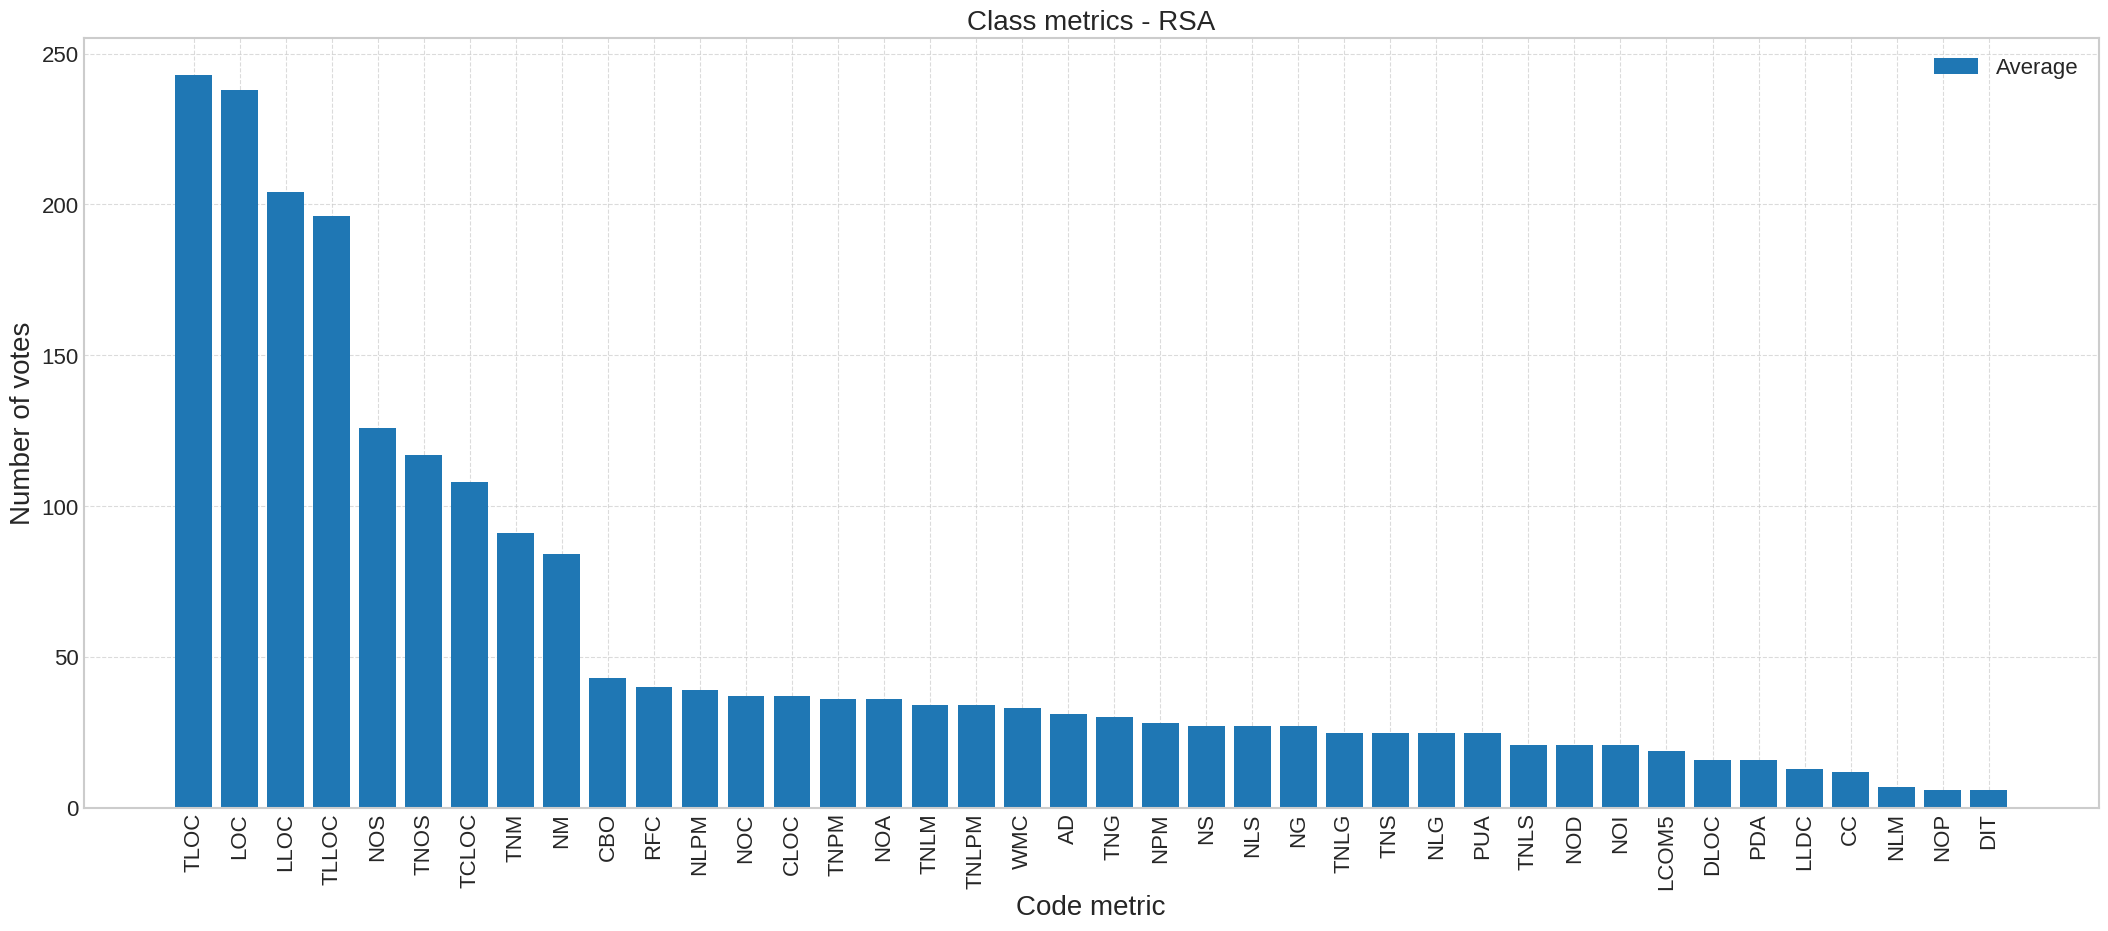

In [ ]:
plt.figure(figsize=(26, 10))
plt.bar(class_metrics_votes_avg_sorted_rsa.keys(), class_metrics_votes_avg_sorted_rsa.values(), label='Average')
plt.xlabel('Code metric')
plt.ylabel('Number of votes')
plt.title('Class metrics - RSA')
plt.xticks(rotation=90)
plt.legend()

# setting xticks for tikz
plt.xticks(range(len(class_metrics_votes_avg_sorted_rsa.keys())), class_metrics_votes_avg_sorted_rsa.keys())

tikzplotlib.save("class_metrics_votes_split_rsa.tex")
plt.show()

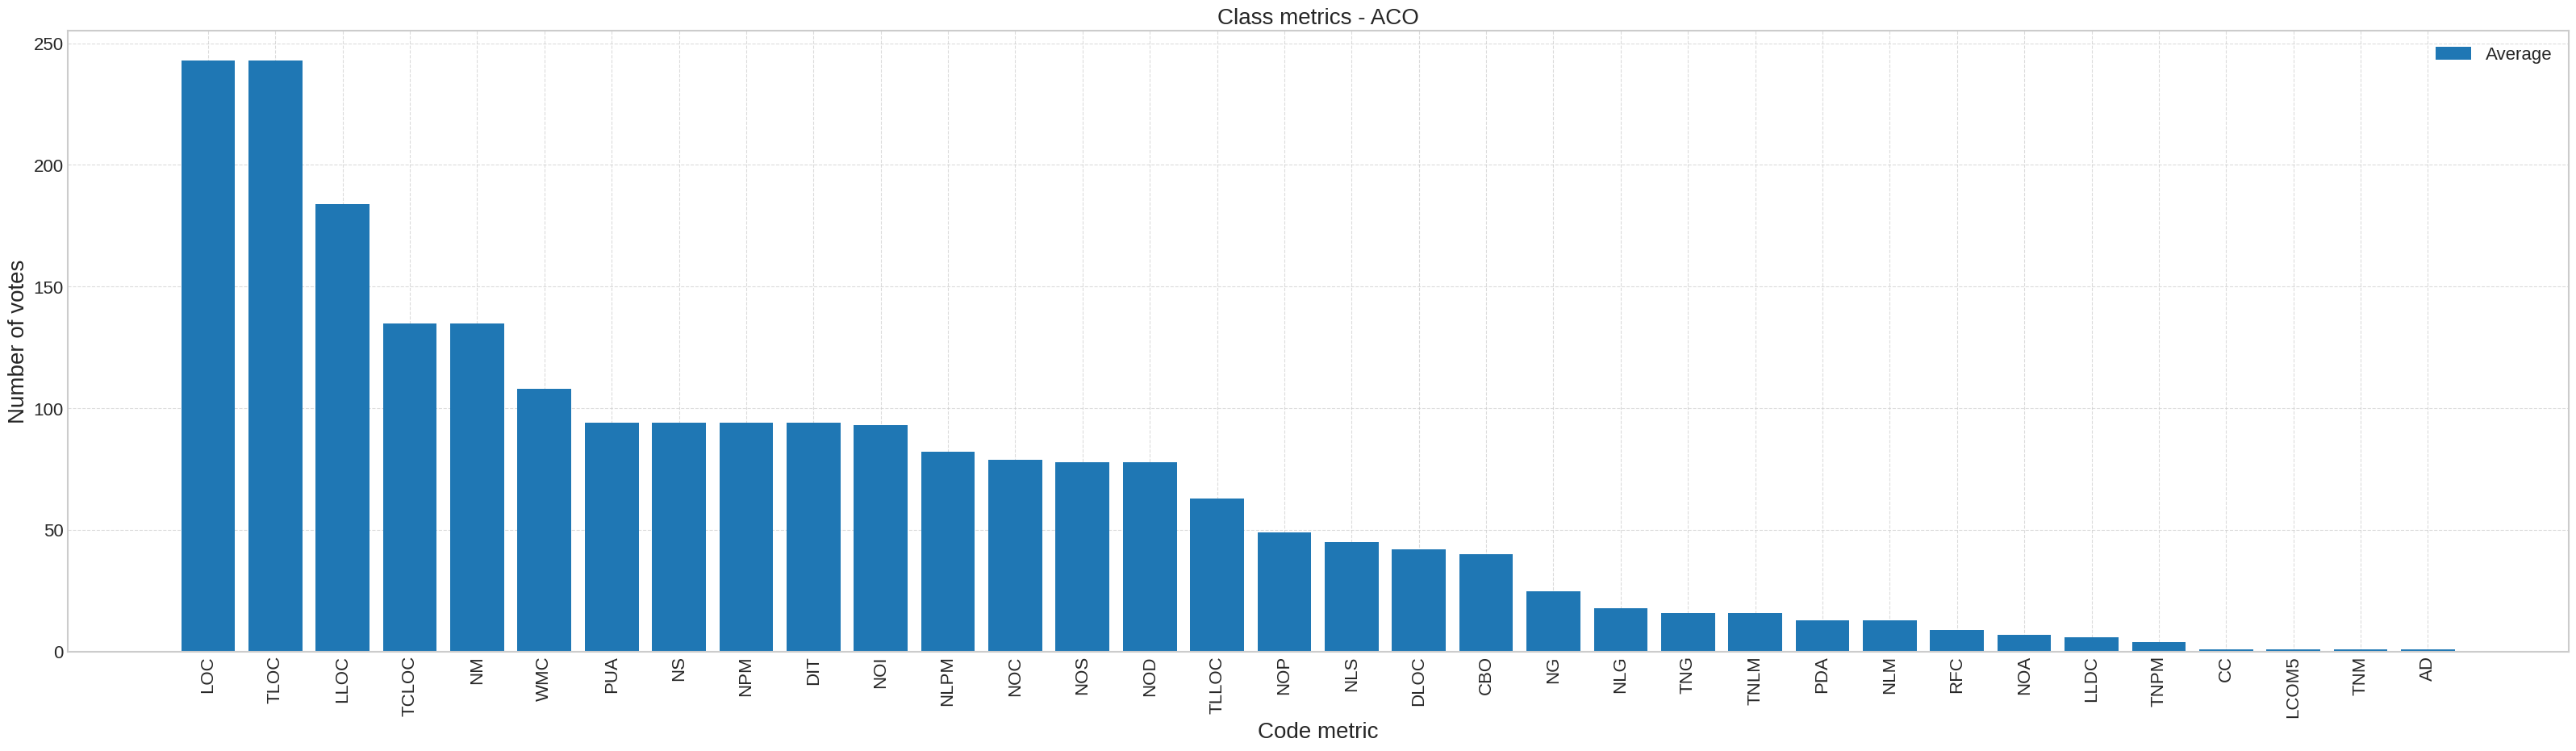

In [ ]:
plt.figure(figsize=(40, 10))
plt.bar(class_metrics_votes_avg_sorted_aco.keys(), class_metrics_votes_avg_sorted_aco.values(), label='Average')
plt.xlabel('Code metric')
plt.ylabel('Number of votes')
plt.title('Class metrics - ACO')
plt.xticks(rotation=90)
plt.legend()

# setting xticks for tikz
plt.xticks(range(len(class_metrics_votes_avg_sorted_aco.keys())), class_metrics_votes_avg_sorted_aco.keys())

tikzplotlib.save("class_metrics_votes_split_aco.tex")
plt.show()

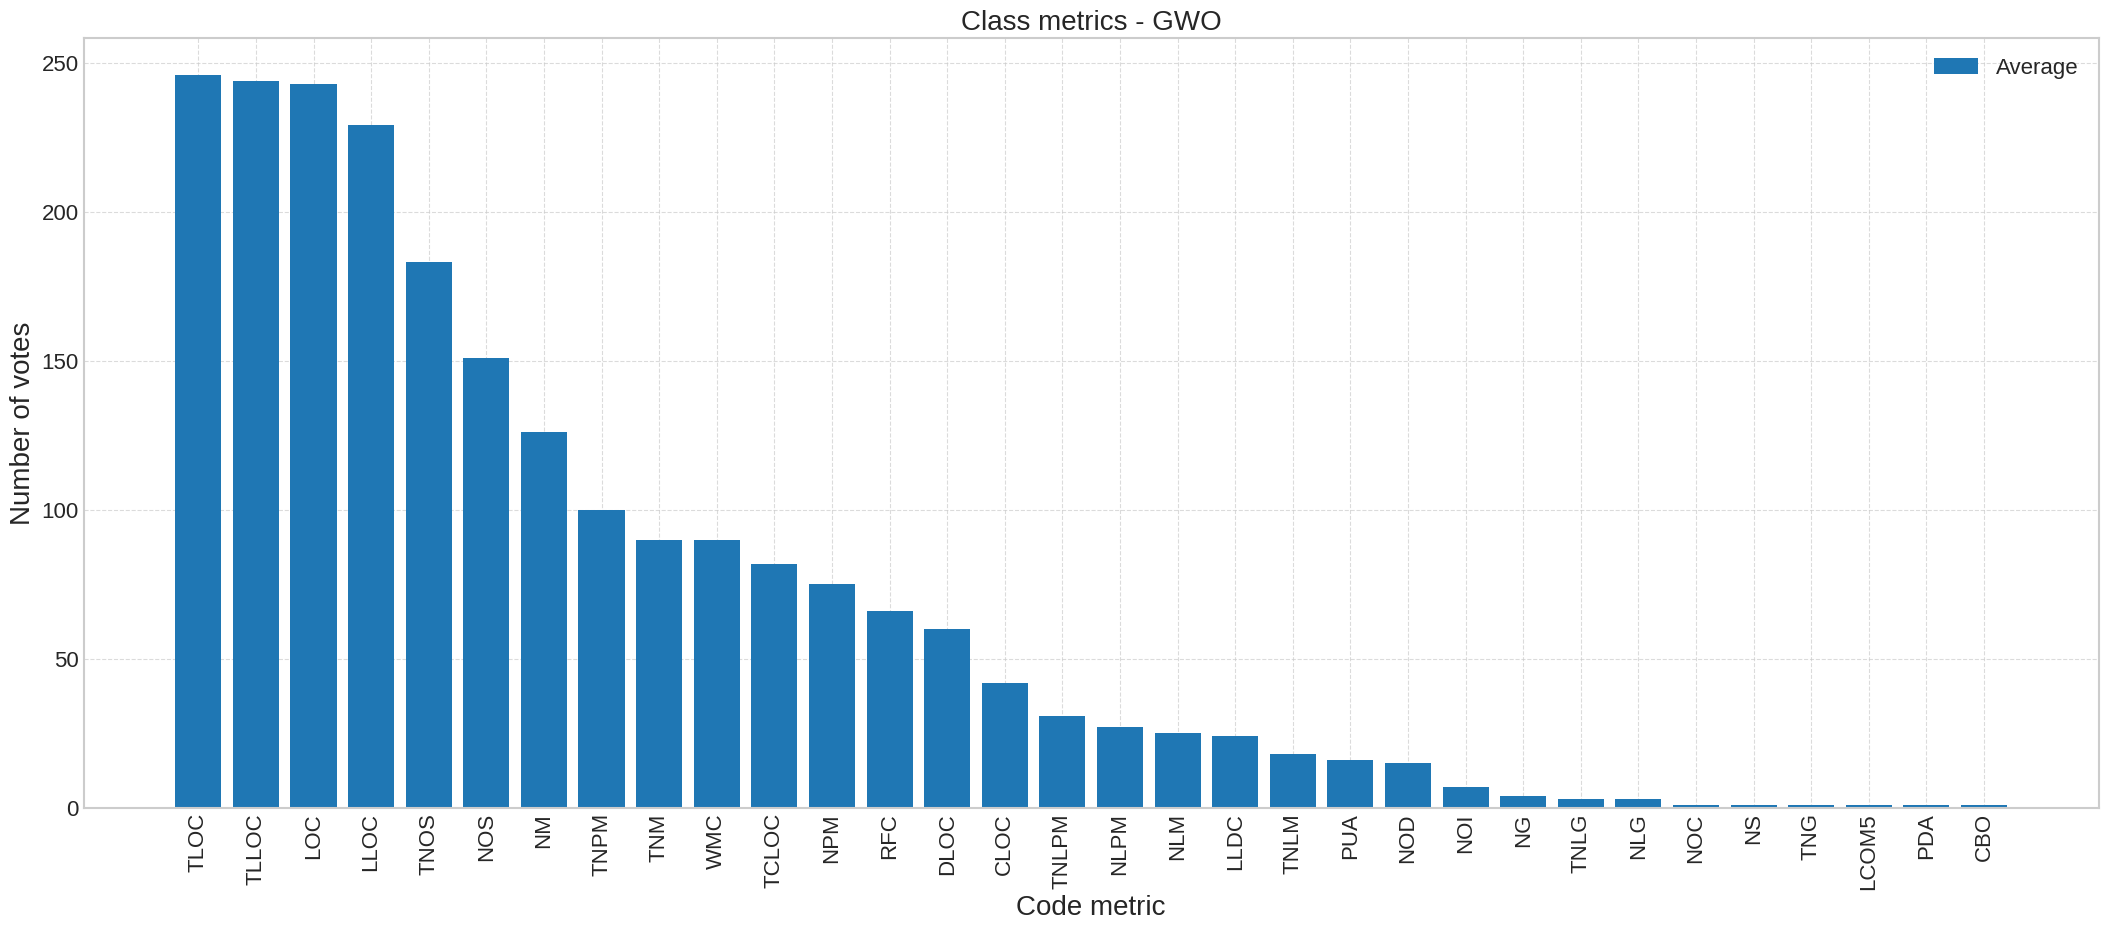

In [ ]:
plt.figure(figsize=(26, 10))
plt.bar(class_metrics_votes_avg_sorted_gwo.keys(), class_metrics_votes_avg_sorted_gwo.values(), label='Average')
plt.xlabel('Code metric')
plt.ylabel('Number of votes')
plt.title('Class metrics - GWO')
plt.xticks(rotation=90)
plt.legend()

# setting xticks for tikz
plt.xticks(range(len(class_metrics_votes_avg_sorted_gwo.keys())), class_metrics_votes_avg_sorted_gwo.keys())

tikzplotlib.save("class_metrics_votes_split_gwo.tex")
plt.show()

Optimal subset of class metrics is:

In [ ]:
class_optimal_subset_rsa = list(class_metrics_votes_avg_sorted_rsa.keys())[:optimal_class_k]
class_optimal_subset_rsa

NameError: name 'class_metrics_votes_avg_sorted_rsa' is not defined

In [ ]:
def get_method_name(i):
    return collected_metrics[project][1].columns[i]

In [ ]:
method_metrics_votes_rsa_ = {get_method_name(k): (v + method_metrics_votes_rsa.get(k, 0)) for k, v in method_metrics_votes_rsa.items()}
method_metrics_votes_avg_sorted_rsa = {k: v for k, v in sorted(method_metrics_votes_rsa_.items(), key=lambda item: item[1], reverse=True)}
method_metrics_votes_avg_sorted_rsa

NameError: name 'method_metrics_votes_rsa' is not defined

In [ ]:
method_metrics_votes_gwo_ = {get_method_name(k): (v + method_metrics_votes_gwo.get(k, 0)) for k, v in method_metrics_votes_gwo.items()}
method_metrics_votes_avg_sorted_gwo = {k: v for k, v in sorted(method_metrics_votes_gwo_.items(), key=lambda item: item[1], reverse=True)}
method_metrics_votes_avg_sorted_gwo

{'TLOC': 328,
 'LOC': 328,
 'TLLOC': 326,
 'LLOC': 304,
 'NOS': 104,
 'TCLOC': 84,
 'TNOS': 76,
 'CLOC': 48,
 'LLDC': 14,
 'DLOC': 10,
 'NUMPAR': 10,
 'NOI': 6,
 'McCC': 2}

In [ ]:
method_metrics_votes_aco_ = {get_method_name(k): (v + method_metrics_votes_aco.get(k, 0)) for k, v in method_metrics_votes_aco.items()}
method_metrics_votes_avg_sorted_aco = {k: v for k, v in sorted(method_metrics_votes_aco_.items(), key=lambda item: item[1], reverse=True)}
method_metrics_votes_avg_sorted_aco

{'TLOC': 328,
 'LOC': 326,
 'TLLOC': 324,
 'TNOS': 320,
 'LLOC': 266,
 'TCLOC': 58,
 'McCC': 4,
 'NUMPAR': 4,
 'LLDC': 4,
 'NOI': 2,
 'NOS': 2,
 'DLOC': 2}

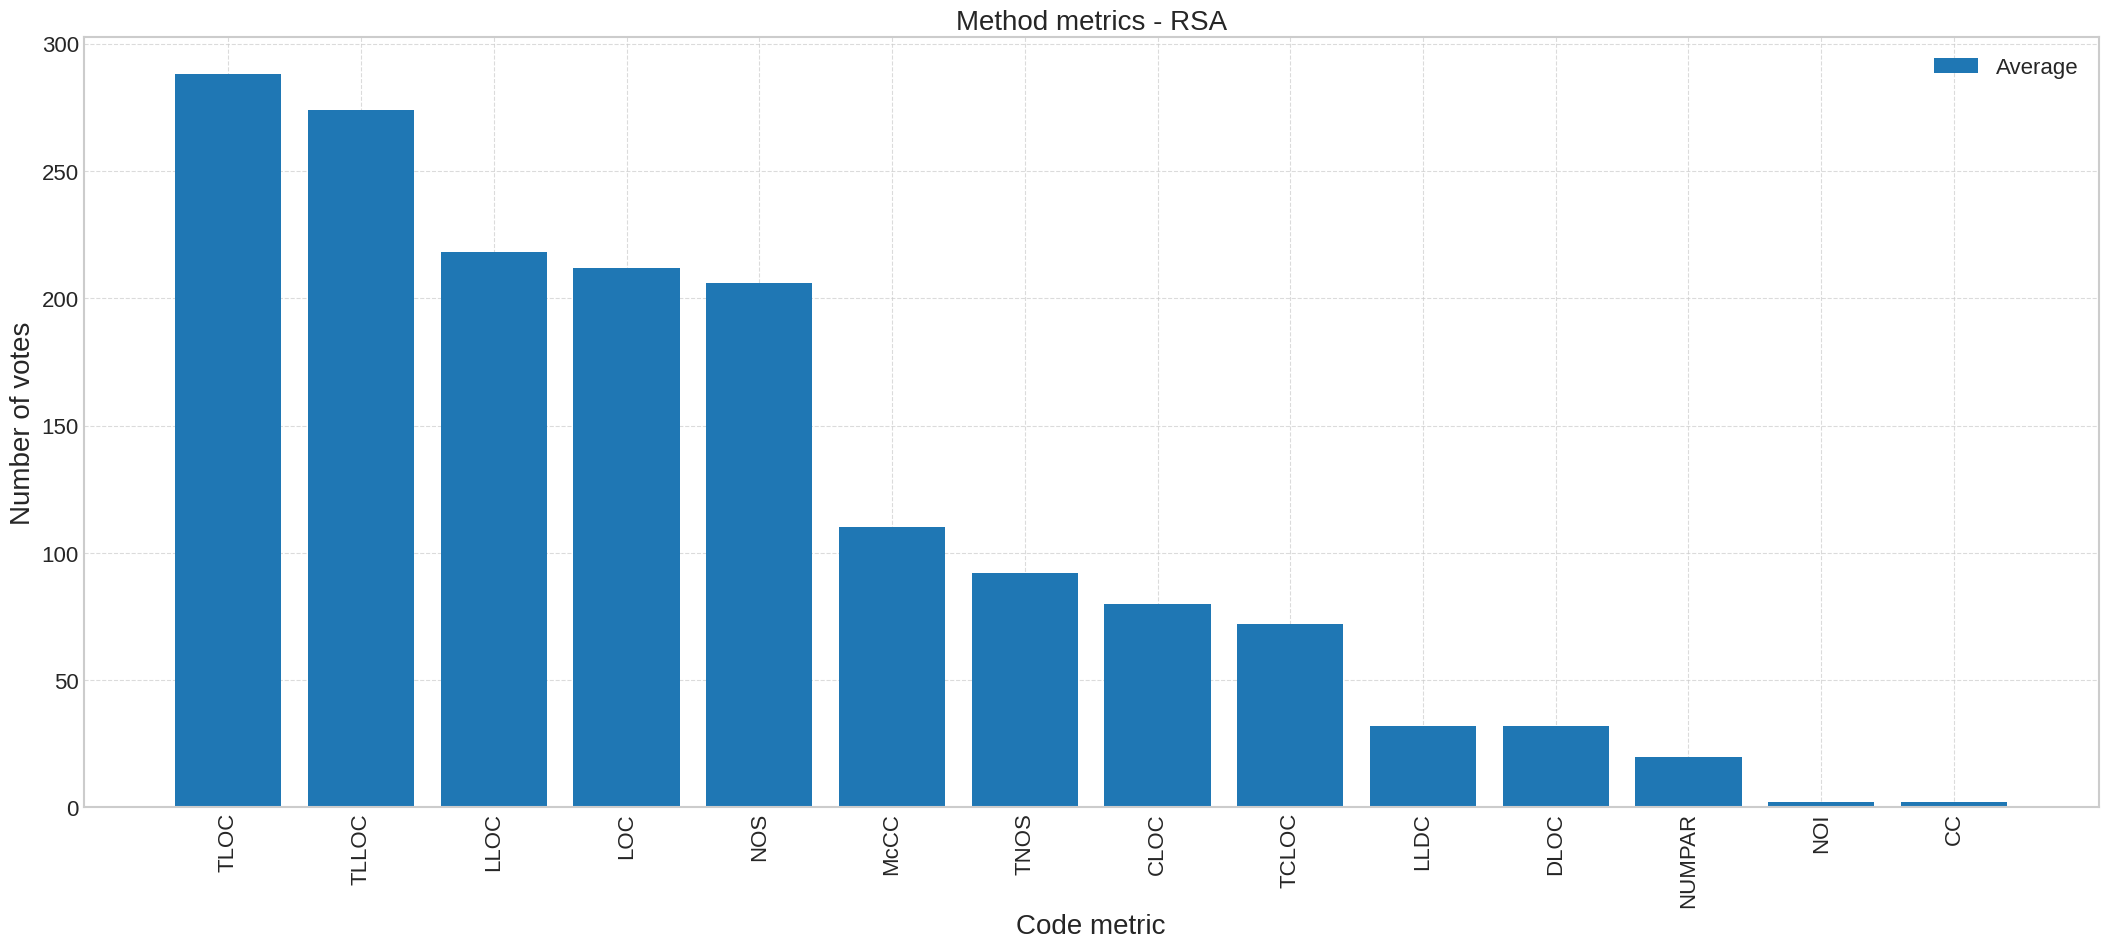

In [ ]:
plt.figure(figsize=(26, 10))
plt.bar(method_metrics_votes_avg_sorted_rsa.keys(), method_metrics_votes_avg_sorted_rsa.values(), label='Average')
plt.xlabel('Code metric')
plt.ylabel('Number of votes')
plt.title('Method metrics - RSA')
plt.xticks(rotation=90)
plt.legend()

# setting xticks for tikz
plt.xticks(range(len(method_metrics_votes_avg_sorted_rsa.keys())), method_metrics_votes_avg_sorted_rsa.keys())

tikzplotlib.save("method_metrics_votes_split_rsa.tex")
plt.show()

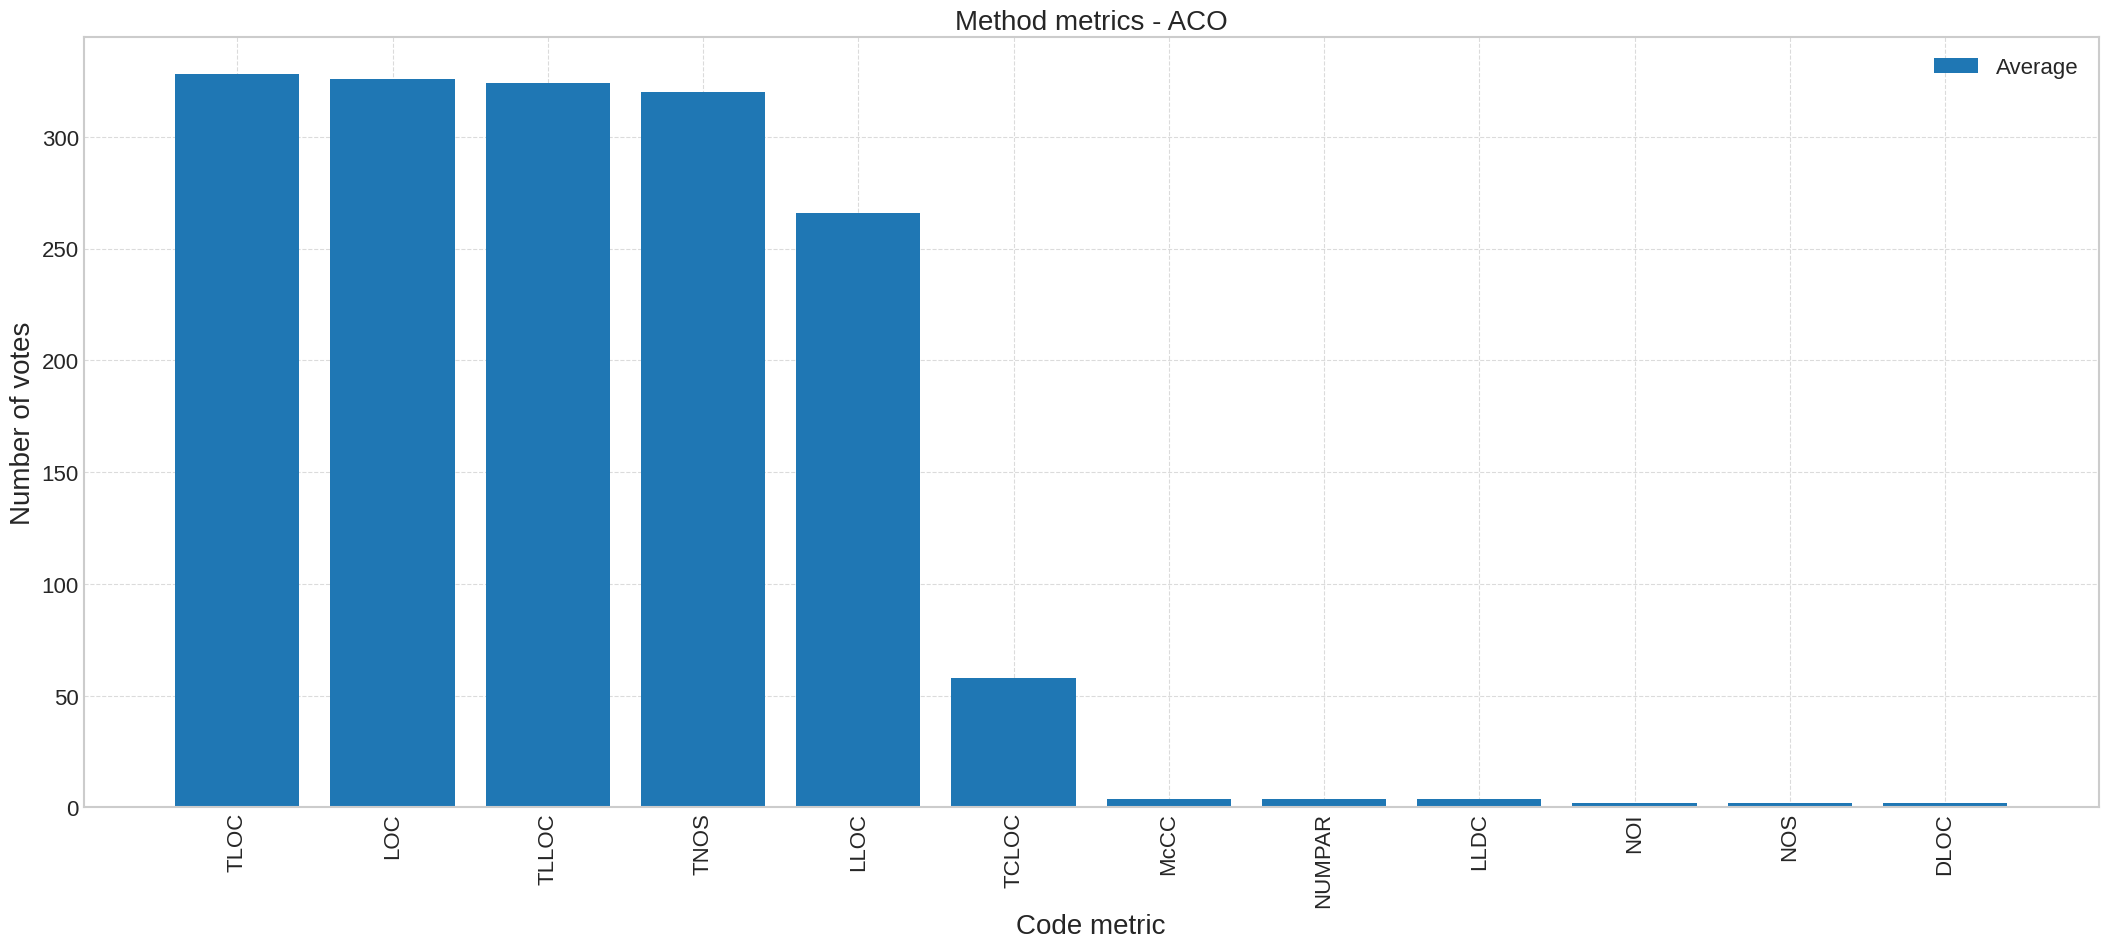

In [ ]:
plt.figure(figsize=(26, 10))
plt.bar(method_metrics_votes_avg_sorted_aco.keys(), method_metrics_votes_avg_sorted_aco.values(), label='Average')
plt.xlabel('Code metric')
plt.ylabel('Number of votes')
plt.title('Method metrics - ACO')
plt.xticks(rotation=90)
plt.legend()

# setting xticks for tikz
plt.xticks(range(len(method_metrics_votes_avg_sorted_aco.keys())), method_metrics_votes_avg_sorted_aco.keys())

tikzplotlib.save("method_metrics_votes_split_aco.tex")
plt.show()

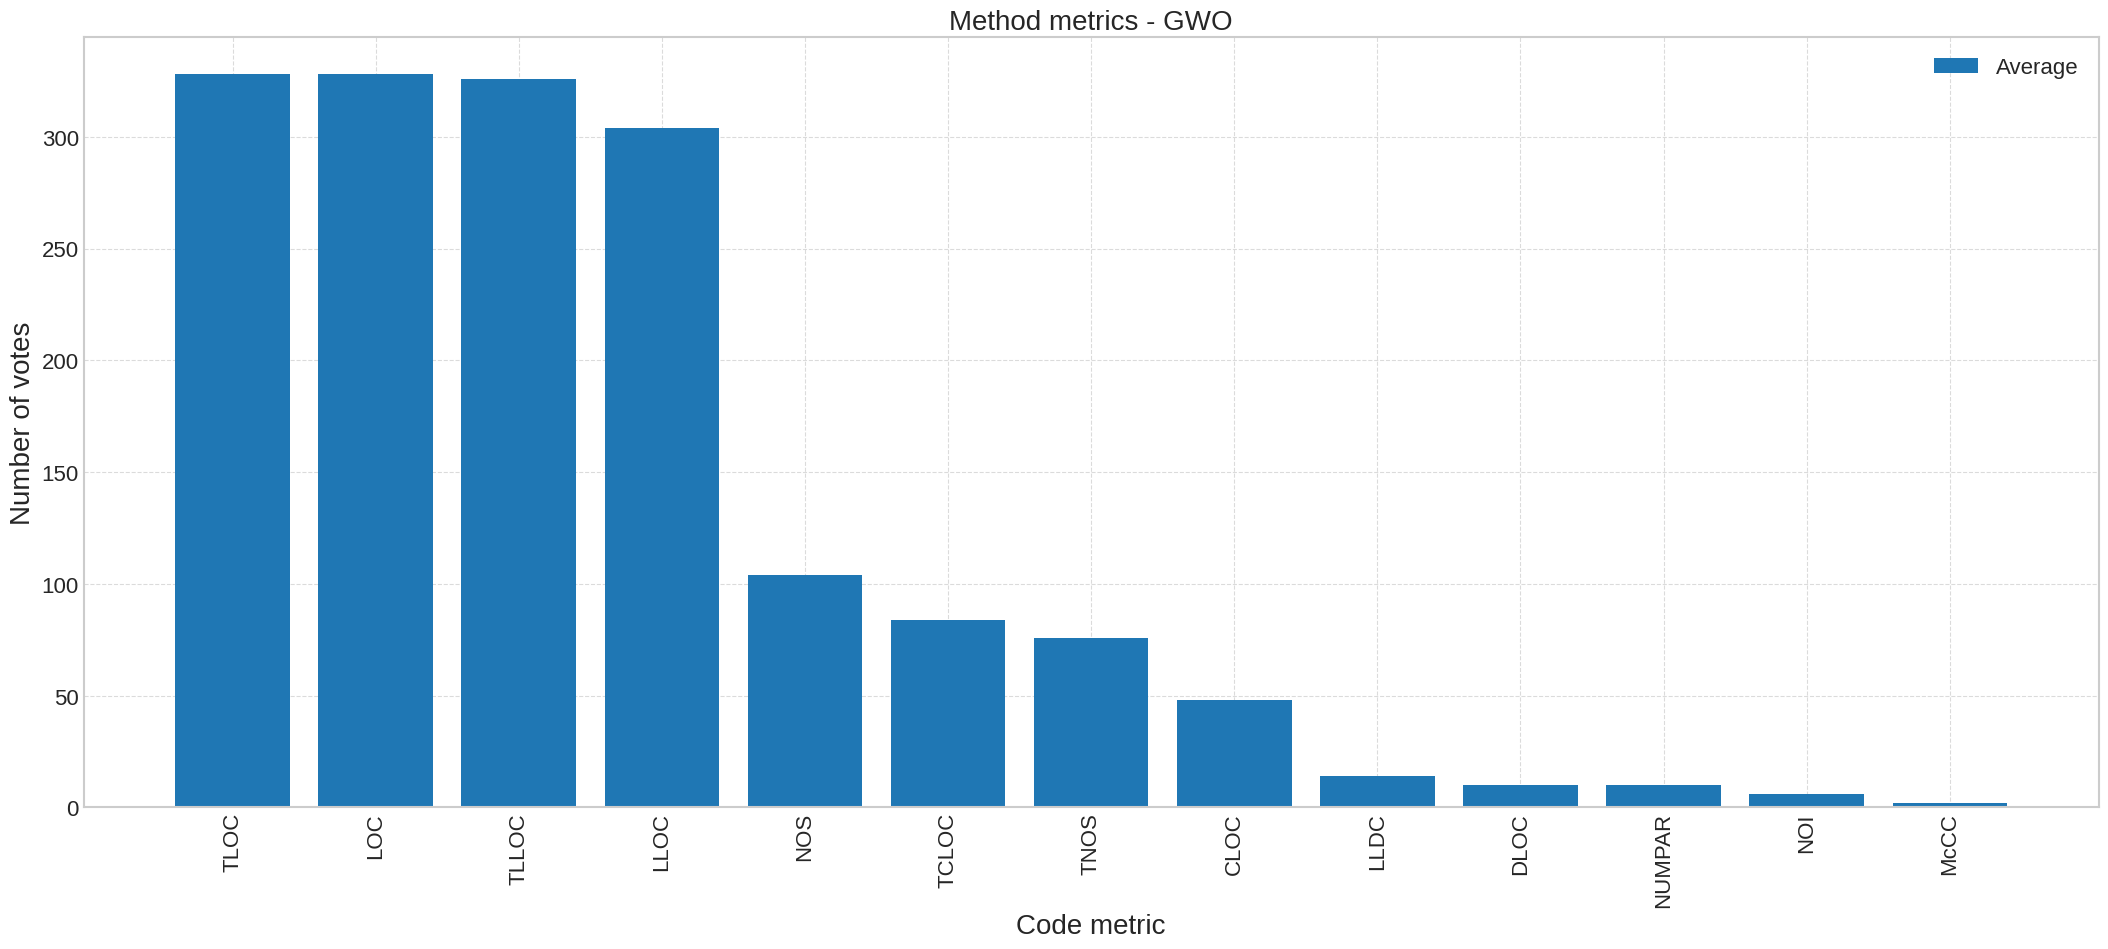

In [ ]:
plt.figure(figsize=(26, 10))
plt.bar(method_metrics_votes_avg_sorted_gwo.keys(), method_metrics_votes_avg_sorted_gwo.values(), label='Average')
plt.xlabel('Code metric')
plt.ylabel('Number of votes')
plt.title('Method metrics - GWO')
plt.xticks(rotation=90)
plt.legend()

# setting xticks for tikz
plt.xticks(range(len(method_metrics_votes_avg_sorted_gwo.keys())), method_metrics_votes_avg_sorted_gwo.keys())

tikzplotlib.save("method_metrics_votes_split_gwo.tex")
plt.show()

In [ ]:
method_optimal_subset = list(method_metrics_votes_avg_sorted_rsa.keys())[:optimal_method_k]
print(list(method_metrics_votes_avg_sorted_rsa.keys())[:optimal_method_k], list(method_metrics_votes_avg_sorted_aco.keys())[:optimal_method_k], list(method_metrics_votes_avg_sorted_gwo.keys())[:optimal_method_k], sep='\n')

['TLOC', 'TLLOC', 'LLOC', 'LOC', 'NOS']
['TLOC', 'LOC', 'TLLOC', 'TNOS', 'LLOC']
['TLOC', 'LOC', 'TLLOC', 'LLOC', 'NOS']


# Validation

In [ ]:
class_optimal_subset_aco = {'LOC': (243 + 243 + 238),
                            'TLOC': (243 + 246 + 243),
                            'LLOC': (184 + 229 + 204),
                            'TCLOC': (135 + 108),
                            'NM': (135 + 126 + 84),
                            'WMC': (108 + 90),
                            'PUA': 94,
                            'NS': 94,
                            'NPM': 94,
                            'DIT': 94,
                            'TLLOC': 244 + 196, 'TNOS': 183 + 117, 'NOS': 151 + 126,
                            'TNPM': 100, 'TNM': 90 + 90, 'CBO': 43
                            }
class_optimal_subset_aco = sorted(class_optimal_subset_aco.items(), key=lambda item: item[1], reverse=True)
class_optimal_subset_aco

[('TLOC', 732),
 ('LOC', 724),
 ('LLOC', 617),
 ('TLLOC', 440),
 ('NM', 345),
 ('TNOS', 300),
 ('NOS', 277),
 ('TCLOC', 243),
 ('WMC', 198),
 ('TNM', 180),
 ('TNPM', 100),
 ('PUA', 94),
 ('NS', 94),
 ('NPM', 94),
 ('DIT', 94),
 ('CBO', 43)]

In [ ]:
class_optimal_subset = ['TLOC', 'LOC', 'LLOC', 'TLLOC', 'NM', 'TNOS', 'NOS', 'TCLOC', 'WMC', 'TNPM']
method_optimal_subset = ['TLOC', 'LOC', 'TLLOC', 'LLOC', 'NOS']

First we will select the optimal subset of metrics for each project using the validation set.

In [ ]:
from sklearn.model_selection import train_test_split

projects_train, projects_val = train_test_split(projects, test_size=0.3, random_state=42)
print(f'Number of projects in training set: {len(projects_train)}')
print(f'Number of projects in validation set: {len(projects_val)}')

Number of projects in training set: 82
Number of projects in validation set: 36


In [ ]:
collected_metrics_val = {}
for project in tqdm(projects_val):
    class_metrics_df = collected_metrics[project][0]
    method_metrics_df = collected_metrics[project][1]
    class_metrics_df = class_metrics_df[class_optimal_subset]
    method_metrics_df = method_metrics_df[method_optimal_subset]
    collected_metrics_val[project] = (class_metrics_df, method_metrics_df)

100%|██████████| 36/36 [00:00<00:00, 1194.91it/s]


In [ ]:
collected_metrics_val[projects_val[0]][0].shape, collected_metrics_val[projects_val[0]][1].shape

((36, 10), (453, 5))

In [ ]:
collected_metrics[projects_val[0]][0].shape, collected_metrics[projects_val[0]][1].shape

((36, 40), (453, 14))

In [ ]:
collected_metrics_val[projects_val[0]][0].head()

,TLOC,LOC,LLOC,TLLOC,NM,TNOS,NOS,TCLOC,WMC,TNPM
0,111,111,110,110,6,51,51,0,15,5
1,12,12,11,11,1,5,5,0,2,0
2,343,109,263,268,8,42,42,0,10,12
3,102,82,83,83,5,31,31,0,12,4
4,75,12,3,67,0,27,0,0,0,8


In [ ]:
collected_metrics_val[projects_val[0]][1].head()

,TLOC,LOC,TLLOC,LLOC,NOS
0,16,16,16,16,12
1,21,21,20,20,7
2,11,11,11,11,3
3,23,23,23,23,10
4,30,30,30,30,18


In [ ]:
collected_metrics_val_full = {}
for project in tqdm(projects_val):
    collected_metrics_val_full[project] = collected_metrics[project]

100%|██████████| 36/36 [00:00<00:00, 241205.98it/s]


In [ ]:
collected_metrics_val_full[projects_val[0]][0].head()

,AD,CBO,CC,CLOC,DIT,DLOC,LCOM5,LLDC,LLOC,LOC,...,TNG,TNLG,TNLM,TNLPM,TNLS,TNM,TNOS,TNPM,TNS,WMC
0,0.0,2,0,0,0,0,2,0,110,111,...,0,0,6,5,0,6,51,5,0,15
1,0.0,0,0,0,0,0,1,0,11,12,...,0,0,1,0,0,1,5,0,0,2
2,0.0,8,0,0,0,0,8,0,263,109,...,0,0,14,12,0,14,42,12,0,10
3,0.0,3,0,0,0,0,1,0,83,82,...,0,0,5,4,0,5,31,4,0,12
4,0.0,1,0,0,0,0,0,0,3,12,...,0,0,6,6,0,8,27,8,0,0


In [ ]:
collected_metrics_val_full[projects_val[0]][0].shape, collected_metrics_val_full[projects_val[0]][1].shape

((36, 40), (453, 14))

Now we will compute the fitness function values for each project using the optimal subset of metrics.

In [ ]:
collected_metrics_val[projects[0]][0].isin([np.inf, -np.inf]).values.any()

False

In [ ]:
import pandas as pd
import os
from glob import glob
from tqdm import tqdm
import torch
from sklearn.model_selection import train_test_split

In [ ]:
import torch

def get_distances_torch(X):
    """
    Вычисляет матрицу расстояний, сумму расстояний и сумму квадратов расстояний с использованием PyTorch.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X = torch.tensor(X, dtype=torch.float32, device=device)

    dist_X = torch.cdist(X, X, p=2)
    sum_d = torch.sum(dist_X).item()
    sum_d_squared = torch.sum(dist_X ** 2).item()

    return dist_X.cpu().numpy(), sum_d, sum_d_squared


def optimized_sammons_error_torch(dist_X, sum_d, sum_d_squared, Y):
    """
    Вычисляет ошибку Саммона с использованием PyTorch.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dist_X = torch.tensor(dist_X, dtype=torch.float32, device=device)
    Y = torch.tensor(Y, dtype=torch.float32, device=device)

    dist_Y = torch.cdist(Y, Y, p=2)
    delta = dist_X - dist_Y

    # Вычисление ошибки
    with torch.no_grad():
        error = torch.where(dist_X != 0, (delta ** 2) / dist_X, torch.tensor(0.0, device=device))
        sum_error = torch.sum(error).item()

    # Результат делится на `sum_d`
    if sum_d == 0:
        return float('inf')

    return sum_error / sum_d


def optimized_kruskals_stress_torch(dist_X, sum_d, sum_d_squared, Y):
    """
    Вычисляет стресс Крускала с использованием PyTorch.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dist_X = torch.tensor(dist_X, dtype=torch.float32, device=device)
    Y = torch.tensor(Y, dtype=torch.float32, device=device)

    dist_Y = torch.cdist(Y, Y, p=2)
    delta = dist_X - dist_Y

    # Вычисление стресса
    with torch.no_grad():
        sum_stress = torch.sum(delta ** 2).item()

    return sum_stress / sum_d_squared if sum_d_squared != 0 else 0


In [ ]:
class_level_validation_results = pd.DataFrame(columns=['project_name', 'sammon', 'kruskal'])
method_level_validation_results = pd.DataFrame(columns=['project_name', 'sammon', 'kruskal'])

In [ ]:
for project in tqdm(projects_val):
    class_metrics_df = collected_metrics_val[project][0]
    method_metrics_df = collected_metrics_val[project][1]
    class_metrics_df_full = collected_metrics_val_full[project][0].dropna()
    method_metrics_df_full = collected_metrics_val_full[project][1].dropna()

    method_metrics_df = method_metrics_df.loc[method_metrics_df_full.index].values
    method_metrics_df_full = method_metrics_df_full.values
    class_metrics_df = class_metrics_df.loc[class_metrics_df_full.index].values
    class_metrics_df_full = class_metrics_df_full.values

    class_dist, class_sum_d, class_sum_d_squared = get_distances_torch(class_metrics_df_full)
    method_dist, method_sum_d, method_sum_d_squared = get_distances_torch(method_metrics_df_full)

    class_level_sammon = optimized_sammons_error_torch(class_dist, class_sum_d, class_sum_d_squared, class_metrics_df)
    class_level_kruskal = np.sqrt(optimized_kruskals_stress_torch(class_dist, class_sum_d, class_sum_d_squared, class_metrics_df))

    method_level_sammon = optimized_sammons_error_torch(method_dist, method_sum_d, method_sum_d_squared, method_metrics_df)
    method_level_kruskal = np.sqrt(optimized_kruskals_stress_torch(method_dist, method_sum_d, method_sum_d_squared, method_metrics_df))

    pd.concat([class_level_validation_results, pd.DataFrame([{'project_name': project, 'sammon': class_level_sammon, 'kruskal': class_level_kruskal}])], ignore_index=True)

    class_level_validation_results = pd.concat([class_level_validation_results, pd.DataFrame([{'project_name': project, 'sammon': class_level_sammon, 'kruskal': class_level_kruskal}])], ignore_index=True)
    method_level_validation_results = pd.concat([method_level_validation_results, pd.DataFrame([{'project_name': project, 'sammon': method_level_sammon, 'kruskal': method_level_kruskal}])], ignore_index=True)

class_level_validation_results.head()


  0%|          | 0/36 [00:00<?, ?it/s]<ipython-input-51-ca4561338478>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat([class_level_validation_results, pd.DataFrame([{'project_name': project, 'sammon': class_level_sammon, 'kruskal': class_level_kruskal}])], ignore_index=True)
<ipython-input-51-ca4561338478>:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  class_level_validation_results = pd.concat([class_level_validation_results, pd.DataFrame([{'project_name': project, 'sammon': clas

,project_name,sammon,kruskal
0,lunadream_XWall,0.000492,0.019715
1,rocksdanister_lively,0.009582,0.058385
2,aloneguid_parquet-dotnet,0.005520,0.077842
3,hudec117_Mpv.NET-lib-,0.007188,0.043137
4,dotnetprojects_DotNetSiemensPLCToolBoxLibrary,0.005126,0.023278


In [ ]:
project = 'UnigramDev_Unigram'
class_metrics_df = collected_metrics_val[project][0]
class_metrics_df_full = collected_metrics_val_full[project][0].dropna()
class_metrics_df = class_metrics_df.loc[class_metrics_df_full.index].values
class_metrics_df_full = class_metrics_df_full.values
class_dist, class_sum_d, class_sum_d_squared = get_distances(class_metrics_df_full)
optimized_sammons = optimized_sammons_error(class_dist, class_sum_d, class_sum_d_squared, class_metrics_df)
optimized_kruskals = np.sqrt(optimized_kruskals_stress(class_dist, class_sum_d, class_sum_d_squared, class_metrics_df))
naive_sammons = sammons_error(class_metrics_df_full, class_metrics_df)
naive_kruskals = np.sqrt(kruskals_stress(class_metrics_df_full, class_metrics_df))

print(optimized_sammons, optimized_kruskals)
print(naive_sammons, naive_kruskals)

0.0021563609897918556 0.031057410242497977
0.002156360989791856 0.031057410242497974


In [ ]:
# clear memory
import gc
gc.collect()

157

In [ ]:
class_level_validation_results

,project_name,sammon,kruskal
0,lunadream_XWall,0.000492,0.019715
1,rocksdanister_lively,0.009582,0.058385
2,aloneguid_parquet-dotnet,0.005520,0.077842
3,hudec117_Mpv.NET-lib-,0.007188,0.043137
4,dotnetprojects_DotNetSiemensPLCToolBoxLibrary,0.005126,0.023278
5,zlynn1990_SpaceSim,0.053343,0.187395
6,mono_taglib-sharp,0.014633,0.101247
7,bitbeans_SimpleDnsCrypt,0.003670,0.028641
8,saucepleez_taskt,0.007522,0.037695
9,mperdeck_jsnlog,0.017537,0.087356


In [ ]:
method_level_validation_results

,project_name,sammon,kruskal
0,lunadream_XWall,0.007613,0.025959
1,rocksdanister_lively,0.029344,0.072449
2,aloneguid_parquet-dotnet,0.030807,0.135013
3,hudec117_Mpv.NET-lib-,0.035623,0.097621
4,dotnetprojects_DotNetSiemensPLCToolBoxLibrary,0.019140,0.050905
5,zlynn1990_SpaceSim,0.019922,0.093345
6,mono_taglib-sharp,0.105062,0.122226
7,bitbeans_SimpleDnsCrypt,0.040226,0.077250
8,saucepleez_taskt,0.037651,0.186250
9,mperdeck_jsnlog,0.062189,0.166284


In [ ]:
class_level_validation_results.to_csv('class_level_validation_results.csv', index=False)
method_level_validation_results.to_csv('method_level_validation_results.csv', index=False)

In [ ]:
class_level_validation_results = pd.read_csv('class_level_validation_results.csv')
method_level_validation_results = pd.read_csv('method_level_validation_results.csv')